
# ALAD - Toy examples¶

This is the notebook that generated Figure 2 in "Adversarially learnt anomaly detection" Credits : https://github.com/ChunyuanLI/ALICE

## Imports


In [1]:
%matplotlib inline

import os
import pdb


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import torch as torch
import torch.nn as nn

from utils.data_gmm import GMM_distribution, sample_GMM, plot_GMM
from utils.data_utils import shuffle, iter_data, ToyDataset
from tqdm import tqdm
import sklearn.datasets

In [3]:

""" parameters """

DATASET = '4gaussians' # 5gaussians, swiss_roll, s_curve
N_NOISY = 100


device = 'cuda'

n_epoch = 600
batch_size  = 1024
dataset_size_x = 512*4
dataset_size_z = 512*4

dataset_size_x_test = 512*2
dataset_size_z_test = 512*2

input_dim = 2
latent_dim = 2
eps_dim = 2

n_layer_disc  = 2
n_hidden_disc = 256
n_layer_gen   = 3
n_hidden_gen  = 256
n_layer_inf   = 2
n_hidden_inf  = 256

In [4]:
""" Create directory for results """
result_dir = 'results/alad_toy/'
directory = result_dir
if not os.path.exists(directory):
    os.makedirs(directory)

## Training dataset

#### 4 or 5 GMM

In [5]:
""" Create dataset """

def four_five_gaussians(p1=0):
    # create X dataset
    global dataset_size_x
    means_x = map(lambda x:  np.array(x), [[2, 2],
                                          [-2, -2],
                                          [2, -2],
                                          [-2, 2],
                                           [0, 0]])
    
    means_x = list(means_x)
    std_x = 0.02
    variances_x = [np.eye(2) * std_x for _ in means_x]

    #contamination = 4.0*p/(1-p)
    priors_x = np.array([1.0, 1.0, 1.0, 1.0, p1])
    priors_x /= sum(priors_x)
    #print(priors_x)
    gaussian_mixture = GMM_distribution(means=means_x,
                                                   variances=variances_x,
                                                   priors=priors_x)
    dataset_x = sample_GMM(dataset_size_x, means_x, variances_x, priors_x, sources=('features', ))
    return dataset_x





You can control the level of the fifth gaussian in the training set with the $p$ parameter

Generate training dataset


In [6]:
dataset_x = four_five_gaussians(p1=0.0)
save_path_x = result_dir + 'X_4gmm_data_train.png'

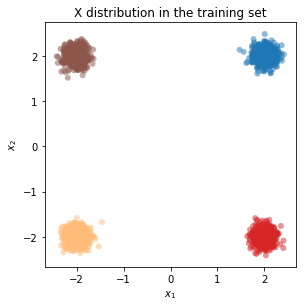

In [7]:
## input x
X_dataset  = dataset_x.data['samples']
X_targets = dataset_x.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_dataset[:, 0], X_dataset[:, 1], c=cm.tab20(X_targets.astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.set_title("X distribution in the training set" )
ax.axis('on')
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()


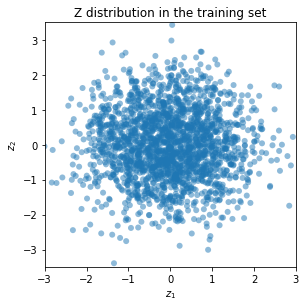

In [8]:


# create Z dataset
means_z = map(lambda x:  np.array(x), [[0, 0]])
means_z = list(means_z)
std_z = 1.0
variances_z = [np.eye(2) * std_z for _ in means_z]
priors_z = [1.0/len(means_z) for _ in means_z]

dataset_z = sample_GMM(dataset_size_z, means_z, variances_z, priors_z, sources=('features', ))
save_path_z = result_dir + 'Z_gmm_data_train.png'

##  input z
Z_dataset = dataset_z.data['samples']
Z_labels  = dataset_z.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_dataset[:, 0], Z_dataset[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.set_title("Z distribution in the training set")
ax.axis('on')
plt.savefig(save_path_z, transparent=True, bbox_inches='tight')
plt.show()



## Networks

In [15]:
""" Networks """

# Models constructors takes tensor arguments only to get input shapes for networks


class Generative_Network(nn.Module):
    def __init__(self,x, input_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Generative_Network, self).__init__()
        layers = []
        self.z = z.to(device)
        z_shape = list(z.shape)[1]
            
        layers.append(nn.Linear(z_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,input_dim).to(device))
        self.gn = nn.Sequential(*layers)
           
            
    def forward(self,z):
        return self.gn(z.to(device))


class Inference_Network(nn.Module):
    def __init__(self, x, latent_dim,n_layer, n_hidden, eps_dim, reuse = False):
        super(Inference_Network, self).__init__()
        self.x = x.to(device)
        layers = []
        x_shape = list(x.shape)[1]
        layers.append(nn.Linear(input_dim, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layer-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,latent_dim).to(device))
        self.infn = nn.Sequential(*layers)
            
    def forward(self,x):
        return self.infn(x.to(device))

    
class Data_Network_xz(nn.Module,):
    def __init__(self,x, z, n_layers=2, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xz, self).__init__()
        layers = []
        
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.activation_fn = activation_fn
        self.reuse = reuse
        self.x = x.to(device)
        self.z = z.to(device)
        self.h = torch.cat((x, z), 1).to(device)
        
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        
        if activation_fn:
            layers.append(activation_fn.to(device))
            
        self.dn_xz = nn.Sequential(*layers)
         
        
    def forward(self,x,z):
        h = torch.cat((x.to(device),z.to(device)), 1)
        res = self.dn_xz(h)
        return res
    
    
class Data_Network_xx(nn.Module):
    def __init__(self,x, x_hat, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_xx, self).__init__()
        layers = []
        self.h = torch.cat( (x, x_hat), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_xx = nn.Sequential(*layers)
        
    def forward(self,x,x_hat):
        h = torch.cat( (x.to(device), x_hat.to(device)), 1)
        res = self.dn_xx(h)
        return res
    
    
class Data_Network_zz(nn.Module):
    def __init__(self,z, z_prime, n_layers=1, n_hidden=128, activation_fn=None,reuse=False):
        super(Data_Network_zz, self).__init__()
        layers = []
        self.h = torch.cat( (z, z_prime), 1).to(device)
        h_shape = list(self.h.shape)[1]
        
        layers.append(nn.Linear(h_shape, n_hidden).to(device))
        layers.append(nn.ReLU())
          
        for i in range(0, n_layers-1):
            layers.append(nn.Linear(n_hidden,n_hidden).to(device))
            layers.append(nn.ReLU().to(device))
            
        layers.append(nn.Linear(n_hidden,1).to(device))
        if activation_fn:
            layers.append(activation_fn.to(device))
        self.dn_zz = nn.Sequential(*layers)
        
    def forward(self, z, z_prime):
        h = torch.cat( (z.to(device), z_prime.to(device)), 1)
        res = self.dn_zz(h)
        return res

In [16]:


x = torch.ones([batch_size, input_dim],dtype = torch.float)
z = torch.ones([batch_size, latent_dim],dtype = torch.float)   
# decoder and encoder
gen = Generative_Network(z, input_dim , n_layer_gen, n_hidden_gen, eps_dim)
inf = Inference_Network(x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim)
dn_xz = Data_Network_xz(x, z, n_layers=n_layer_disc, n_hidden=n_hidden_disc)
dn_zz = Data_Network_zz(z,z)
dn_xx = Data_Network_xx(x,x)



### Optimizers section:

In [17]:
"""qvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "inference")
pvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generative")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
dvars_xx = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_xx")
dvars_zz = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator_zz")

opt = tf.train.AdamOptimizer(1e-3, beta1=0.5)
train_gen_op =  opt.minimize(gen_loss, var_list=qvars + pvars)
train_disc_op = opt.minimize(disc_loss, var_list=dvars + dvars_xx)"""

# Train disc op does not contain dvars_zz?

disc_params = list(dn_zz.parameters())+list(dn_xz.parameters())+list(dn_xx.parameters())
disc_optimizer = torch.optim.Adam( disc_params, lr=1e-3,betas = (0.5,0.999))

gen_params = list(gen.parameters()) + list(inf.parameters())
gen_optimizer = torch.optim.Adam(gen_params , lr = 1e-3, betas = (0.5,0.999))


### Learning procedure 

In [18]:
"""config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())


FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    i = 0
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        i = i + 1
        for _ in range(1):
            f_d, _ = sess.run([disc_loss, train_disc_op], feed_dict={x: xmb, z:zmb})
        for _ in range(5):                                        #  ??? why 5
            f_g, _ = sess.run([[gen_loss, gen_loss_xz, cost_x], train_gen_op], feed_dict={x: xmb, z:zmb})

        FG.append(f_g)
        FD.append(f_d)

    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))

"""
FG = []
FD = []

for epoch in tqdm( range(n_epoch), total=n_epoch):
    X_dataset= shuffle(X_dataset)
    Z_dataset= shuffle(Z_dataset)
    
    bce = nn.BCELoss()
    sigmoid = nn.Sigmoid()

    i = 0
    f_g= [None]*4
    f_d = None
    
    for xmb, zmb in iter_data(X_dataset, Z_dataset, size=batch_size):
        
        x = torch.Tensor(xmb)
        z = torch.Tensor(zmb)
        i = i+1
        
        p_x = gen(z)
        q_z = inf(x)
        
        decoder_logit = dn_xz(p_x, z)
        encoder_logit = dn_xz(x , q_z)
    
        #NB! Not sure if such xz loss description is correct

      
        decoder_loss = bce(sigmoid(decoder_logit),torch.zeros_like(decoder_logit))
        encoder_loss = bce(sigmoid(encoder_logit),torch.ones_like(encoder_logit))
        
        dis_loss_xz =torch.mean(encoder_loss+decoder_loss)

        decoder_loss2 = bce(sigmoid(decoder_logit),torch.ones_like(decoder_logit))
        encoder_loss2 = bce(sigmoid(encoder_logit),torch.zeros_like(encoder_logit))

        gen_loss_xz = torch.mean((decoder_loss2))  + (torch.mean(encoder_loss2))
        
        
        """rec_z = inference_network(p_x, latent_dim, n_layer_inf, n_hidden_inf, eps_dim, reuse=True)
            rec_x = generative_network(q_z, input_dim , n_layer_gen, n_hidden_gen,  eps_dim, reuse=True)
        """
        
        rec_z = inf(p_x)
        rec_x = gen(q_z)
        

        """
        x_logit_real = data_network_xx(x, x)
        x_logit_fake = data_network_xx(x, rec_x, reuse=True)
        z_logit_real = data_network_zz(z, z)
        z_logit_fake = data_network_zz(z, rec_z,  reuse=True)
        """ 
        x_logit_real = dn_xx(x,x)
        x_logit_fake = dn_xx(x,rec_x)
        z_logit_real = dn_zz(z,z)
        z_logit_fake = dn_zz(z,rec_z)

        """
        x_sigmoid_real = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.ones_like(x_logit_real))
        x_sigmoid_fake = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.zeros_like(x_logit_fake))
        """
        x_sigmoid_real = bce(sigmoid(x_logit_real),torch.ones_like(x_logit_real))
        x_sigmoid_fake = bce(sigmoid(x_logit_fake),torch.zeros_like(x_logit_fake))

        x_sigmoid_real2 = bce(sigmoid(x_logit_real),torch.zeros_like(x_logit_real))
        x_sigmoid_fake2 = bce(sigmoid(x_logit_fake),torch.ones_like(x_logit_fake))

        """x_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_real, labels=tf.zeros_like(x_logit_real))
        x_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit_fake, labels=tf.ones_like(x_logit_fake))

        z_sigmoid_real2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_real, labels=tf.zeros_like(z_logit_real))
        z_sigmoid_fake2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=z_logit_fake, labels=tf.ones_like(z_logit_fake))"""

        z_sigmoid_real = bce(sigmoid(z_logit_real),torch.ones_like(z_logit_real))
        z_sigmoid_fake = bce(sigmoid(z_logit_fake),torch.zeros_like(z_logit_fake))

        z_sigmoid_real2 = bce(sigmoid(z_logit_real),torch.zeros_like(z_logit_real))
        z_sigmoid_fake2 = bce(sigmoid(z_logit_fake),torch.ones_like(z_logit_fake))

        """
        dis_loss_x = tf.reduce_mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = tf.reduce_mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z
        """
        dis_loss_x = torch.mean(x_sigmoid_real + x_sigmoid_fake)
        dis_loss_z = torch.mean(z_sigmoid_real + z_sigmoid_fake)
        disc_loss = dis_loss_xz + dis_loss_x + dis_loss_z

        cost_x = torch.mean(x_sigmoid_real2 + x_sigmoid_fake2) 
        cost_z = torch.mean(z_sigmoid_real2 + z_sigmoid_fake2)
        gen_loss = gen_loss_xz + cost_x + cost_z
    
        for _ in range(1):
            disc_optimizer.zero_grad()
            disc_loss.backward(retain_graph = True)
            disc_optimizer.step()
            f_d = disc_loss.data
            
        # In the original article cycle below repeated 5 times, however for 
        # some reasone in my case it leads to insufficient regularization.
       
        
        for _ in range(2):
            gen_optimizer.zero_grad()
            gen_loss.backward(retain_graph = True)
            gen_optimizer.step()
            f_g = [gen_loss.data, gen_loss_xz.data, cost_x.data ,cost_z.data]
            
        FG.append(f_g)
        FD.append(f_d)
    
    print("epoch %d iter %d: discloss %f genloss %f adv_x %f recons_x %f " % (epoch, i, f_d, f_g[0], f_g[1], f_g[2]))



  0%|          | 3/600 [00:00<04:17,  2.32it/s]

epoch 0 iter 2: discloss 4.144230 genloss 4.357566 adv_x 1.512360 recons_x 1.493480 
epoch 1 iter 2: discloss 4.468311 genloss 4.289903 adv_x 1.690274 recons_x 1.396167 
epoch 2 iter 2: discloss 4.625715 genloss 4.943511 adv_x 2.589129 recons_x 1.425921 
epoch 3 iter 2: discloss 3.864037 genloss 4.849337 adv_x 1.914260 recons_x 1.619427 


  1%|          | 7/600 [00:00<02:24,  4.11it/s]

epoch 4 iter 2: discloss 4.057462 genloss 5.171602 adv_x 2.033684 recons_x 1.653226 
epoch 5 iter 2: discloss 4.399396 genloss 4.891073 adv_x 1.869762 recons_x 1.596855 
epoch 6 iter 2: discloss 5.576922 genloss 3.973932 adv_x 1.292516 recons_x 1.333900 
epoch 7 iter 2: discloss 8.484472 genloss 3.014107 adv_x 1.022875 recons_x 0.849611 


  2%|▏         | 11/600 [00:01<01:29,  6.56it/s]

epoch 8 iter 2: discloss 4.359239 genloss 4.782275 adv_x 2.141798 recons_x 1.007633 
epoch 9 iter 2: discloss 3.525252 genloss 5.202917 adv_x 2.055064 recons_x 1.585858 
epoch 10 iter 2: discloss 3.855373 genloss 4.813886 adv_x 1.831287 recons_x 1.560076 


  2%|▏         | 13/600 [00:01<01:13,  7.93it/s]

epoch 11 iter 2: discloss 4.021379 genloss 4.651069 adv_x 1.730760 recons_x 1.547674 
epoch 12 iter 2: discloss 4.215880 genloss 4.533100 adv_x 1.675529 recons_x 1.527664 
epoch 13 iter 2: discloss 4.847604 genloss 4.180779 adv_x 1.449843 recons_x 1.457392 


  3%|▎         | 17/600 [00:01<00:57, 10.18it/s]

epoch 14 iter 2: discloss 4.834746 genloss 3.890426 adv_x 1.243393 recons_x 1.420069 
epoch 15 iter 2: discloss 3.887945 genloss 4.754006 adv_x 1.782814 recons_x 1.646545 
epoch 16 iter 2: discloss 3.933480 genloss 4.740176 adv_x 1.722072 recons_x 1.628884 


  4%|▎         | 21/600 [00:01<00:47, 12.10it/s]

epoch 17 iter 2: discloss 4.009688 genloss 4.560528 adv_x 1.570789 recons_x 1.575596 
epoch 18 iter 2: discloss 4.116784 genloss 4.442519 adv_x 1.452721 recons_x 1.551316 
epoch 19 iter 2: discloss 4.208773 genloss 4.366019 adv_x 1.419258 recons_x 1.497428 
epoch 20 iter 2: discloss 4.369105 genloss 4.322954 adv_x 1.376538 recons_x 1.448488 


  4%|▍         | 23/600 [00:02<00:45, 12.72it/s]

epoch 21 iter 2: discloss 4.178628 genloss 4.432913 adv_x 1.490773 recons_x 1.421660 
epoch 22 iter 2: discloss 4.235085 genloss 4.370486 adv_x 1.476385 recons_x 1.437844 
epoch 23 iter 2: discloss 4.585729 genloss 4.186269 adv_x 1.296779 recons_x 1.482931 


  4%|▍         | 27/600 [00:02<00:44, 12.81it/s]

epoch 24 iter 2: discloss 4.185072 genloss 4.235773 adv_x 1.366204 recons_x 1.483411 
epoch 25 iter 2: discloss 4.251678 genloss 4.321635 adv_x 1.464764 recons_x 1.479848 
epoch 26 iter 2: discloss 4.230619 genloss 4.223787 adv_x 1.336533 recons_x 1.497956 


  5%|▌         | 31/600 [00:02<00:40, 13.93it/s]

epoch 27 iter 2: discloss 4.080865 genloss 4.401229 adv_x 1.494574 recons_x 1.530509 
epoch 28 iter 2: discloss 3.985481 genloss 4.461236 adv_x 1.556249 recons_x 1.513259 
epoch 29 iter 2: discloss 3.960645 genloss 4.442055 adv_x 1.541949 recons_x 1.497697 
epoch 30 iter 2: discloss 3.951964 genloss 4.452131 adv_x 1.554436 recons_x 1.489146 


  6%|▌         | 35/600 [00:02<00:36, 15.43it/s]

epoch 31 iter 2: discloss 4.010271 genloss 4.396349 adv_x 1.511008 recons_x 1.472309 
epoch 32 iter 2: discloss 4.070507 genloss 4.352387 adv_x 1.453842 recons_x 1.477883 
epoch 33 iter 2: discloss 4.157122 genloss 4.292323 adv_x 1.377740 recons_x 1.490307 
epoch 34 iter 2: discloss 4.137949 genloss 4.263516 adv_x 1.349078 recons_x 1.494059 


  6%|▋         | 39/600 [00:03<00:34, 16.24it/s]

epoch 35 iter 2: discloss 3.853002 genloss 4.571426 adv_x 1.651459 recons_x 1.499502 
epoch 36 iter 2: discloss 4.006028 genloss 4.479174 adv_x 1.602365 recons_x 1.472850 
epoch 37 iter 2: discloss 4.219241 genloss 4.246806 adv_x 1.386756 recons_x 1.453169 
epoch 38 iter 2: discloss 4.207618 genloss 4.211387 adv_x 1.393473 recons_x 1.418365 


  7%|▋         | 43/600 [00:03<00:34, 16.24it/s]

epoch 39 iter 2: discloss 4.205116 genloss 4.164171 adv_x 1.376581 recons_x 1.395447 
epoch 40 iter 2: discloss 4.072260 genloss 4.363693 adv_x 1.579226 recons_x 1.394210 
epoch 41 iter 2: discloss 4.134354 genloss 4.259150 adv_x 1.469420 recons_x 1.400328 
epoch 42 iter 2: discloss 4.128552 genloss 4.224913 adv_x 1.439619 recons_x 1.395372 


  8%|▊         | 47/600 [00:03<00:33, 16.54it/s]

epoch 43 iter 2: discloss 4.068892 genloss 4.270561 adv_x 1.461557 recons_x 1.414588 
epoch 44 iter 2: discloss 4.115182 genloss 4.232533 adv_x 1.430739 recons_x 1.409822 
epoch 45 iter 2: discloss 4.111561 genloss 4.229848 adv_x 1.435368 recons_x 1.401284 
epoch 46 iter 2: discloss 4.113194 genloss 4.227593 adv_x 1.436473 recons_x 1.396295 


  8%|▊         | 51/600 [00:03<00:33, 16.59it/s]

epoch 47 iter 2: discloss 4.122210 genloss 4.219794 adv_x 1.439924 recons_x 1.386750 
epoch 48 iter 2: discloss 4.120491 genloss 4.221623 adv_x 1.443382 recons_x 1.384844 
epoch 49 iter 2: discloss 4.113149 genloss 4.229261 adv_x 1.446021 recons_x 1.387228 
epoch 50 iter 2: discloss 4.110061 genloss 4.229230 adv_x 1.443467 recons_x 1.391977 


  9%|▉         | 55/600 [00:04<00:33, 16.14it/s]

epoch 51 iter 2: discloss 4.107967 genloss 4.226858 adv_x 1.439922 recons_x 1.389992 
epoch 52 iter 2: discloss 4.109270 genloss 4.223513 adv_x 1.438921 recons_x 1.391019 
epoch 53 iter 2: discloss 4.104795 genloss 4.227103 adv_x 1.444555 recons_x 1.389064 
epoch 54 iter 2: discloss 4.102265 genloss 4.229392 adv_x 1.443339 recons_x 1.389260 


 10%|▉         | 57/600 [00:04<00:37, 14.55it/s]

epoch 55 iter 2: discloss 4.104233 genloss 4.227837 adv_x 1.446385 recons_x 1.385780 
epoch 56 iter 2: discloss 4.081141 genloss 4.253626 adv_x 1.466491 recons_x 1.390347 
epoch 57 iter 2: discloss 4.099364 genloss 4.234247 adv_x 1.450758 recons_x 1.385295 


 10%|█         | 61/600 [00:04<00:36, 14.74it/s]

epoch 58 iter 2: discloss 4.074699 genloss 4.259894 adv_x 1.454126 recons_x 1.411381 
epoch 59 iter 2: discloss 4.095871 genloss 4.236755 adv_x 1.454007 recons_x 1.387229 
epoch 60 iter 2: discloss 4.075748 genloss 4.259104 adv_x 1.465973 recons_x 1.391996 
epoch 61 iter 2: discloss 4.099569 genloss 4.232594 adv_x 1.447889 recons_x 1.388199 


 11%|█         | 65/600 [00:04<00:34, 15.48it/s]

epoch 62 iter 2: discloss 4.093945 genloss 4.238663 adv_x 1.442970 recons_x 1.398828 
epoch 63 iter 2: discloss 4.089995 genloss 4.239564 adv_x 1.435426 recons_x 1.400686 
epoch 64 iter 2: discloss 4.086308 genloss 4.243456 adv_x 1.454964 recons_x 1.390552 
epoch 65 iter 2: discloss 4.063796 genloss 4.267738 adv_x 1.445400 recons_x 1.408961 


 12%|█▏        | 69/600 [00:04<00:32, 16.20it/s]

epoch 66 iter 2: discloss 4.069002 genloss 4.260472 adv_x 1.447394 recons_x 1.415533 
epoch 67 iter 2: discloss 4.103042 genloss 4.227379 adv_x 1.434133 recons_x 1.395734 
epoch 68 iter 2: discloss 4.085622 genloss 4.243912 adv_x 1.438321 recons_x 1.410028 
epoch 69 iter 2: discloss 4.069728 genloss 4.262679 adv_x 1.448079 recons_x 1.420252 


 12%|█▏        | 73/600 [00:05<00:31, 16.56it/s]

epoch 70 iter 2: discloss 4.114357 genloss 4.215766 adv_x 1.417042 recons_x 1.398509 
epoch 71 iter 2: discloss 4.098864 genloss 4.228033 adv_x 1.428745 recons_x 1.392777 
epoch 72 iter 2: discloss 4.068445 genloss 4.259792 adv_x 1.458602 recons_x 1.395611 
epoch 73 iter 2: discloss 4.091889 genloss 4.238640 adv_x 1.448362 recons_x 1.385286 


 13%|█▎        | 77/600 [00:05<00:30, 16.92it/s]

epoch 74 iter 2: discloss 4.088365 genloss 4.240800 adv_x 1.438253 recons_x 1.399196 
epoch 75 iter 2: discloss 4.095526 genloss 4.232765 adv_x 1.433845 recons_x 1.389437 
epoch 76 iter 2: discloss 4.092182 genloss 4.240111 adv_x 1.441173 recons_x 1.389969 
epoch 77 iter 2: discloss 4.095244 genloss 4.237336 adv_x 1.442903 recons_x 1.388564 


 14%|█▎        | 81/600 [00:05<00:30, 17.20it/s]

epoch 78 iter 2: discloss 4.092773 genloss 4.238795 adv_x 1.442159 recons_x 1.389819 
epoch 79 iter 2: discloss 4.106344 genloss 4.222823 adv_x 1.423044 recons_x 1.396875 
epoch 80 iter 2: discloss 4.090986 genloss 4.237597 adv_x 1.428644 recons_x 1.404875 
epoch 81 iter 2: discloss 4.076930 genloss 4.251149 adv_x 1.431650 recons_x 1.410081 


 14%|█▍        | 85/600 [00:05<00:29, 17.39it/s]

epoch 82 iter 2: discloss 4.063823 genloss 4.265641 adv_x 1.446583 recons_x 1.411059 
epoch 83 iter 2: discloss 4.073604 genloss 4.255554 adv_x 1.453996 recons_x 1.396497 
epoch 84 iter 2: discloss 4.084382 genloss 4.244593 adv_x 1.444318 recons_x 1.389022 
epoch 85 iter 2: discloss 4.100831 genloss 4.227417 adv_x 1.420497 recons_x 1.399902 


 15%|█▍        | 89/600 [00:06<00:30, 16.84it/s]

epoch 86 iter 2: discloss 4.045170 genloss 4.289312 adv_x 1.441011 recons_x 1.441738 
epoch 87 iter 2: discloss 4.086963 genloss 4.243437 adv_x 1.432356 recons_x 1.402628 
epoch 88 iter 2: discloss 4.087428 genloss 4.243579 adv_x 1.435701 recons_x 1.395973 
epoch 89 iter 2: discloss 4.036037 genloss 4.296253 adv_x 1.477571 recons_x 1.396842 


 16%|█▌        | 93/600 [00:06<00:29, 17.05it/s]

epoch 90 iter 2: discloss 4.077145 genloss 4.253936 adv_x 1.437204 recons_x 1.407590 
epoch 91 iter 2: discloss 4.068507 genloss 4.262107 adv_x 1.427392 recons_x 1.417202 
epoch 92 iter 2: discloss 4.064322 genloss 4.263631 adv_x 1.452607 recons_x 1.388009 
epoch 93 iter 2: discloss 4.025689 genloss 4.306624 adv_x 1.484253 recons_x 1.403234 


 16%|█▌        | 97/600 [00:06<00:29, 17.17it/s]

epoch 94 iter 2: discloss 4.034230 genloss 4.299660 adv_x 1.469982 recons_x 1.421751 
epoch 95 iter 2: discloss 4.085683 genloss 4.246828 adv_x 1.441326 recons_x 1.392508 
epoch 96 iter 2: discloss 4.106278 genloss 4.223608 adv_x 1.415064 recons_x 1.397422 
epoch 97 iter 2: discloss 3.983484 genloss 4.357350 adv_x 1.477988 recons_x 1.440348 


 17%|█▋        | 101/600 [00:06<00:30, 16.34it/s]

epoch 98 iter 2: discloss 4.028350 genloss 4.310765 adv_x 1.490970 recons_x 1.406248 
epoch 99 iter 2: discloss 4.065133 genloss 4.279527 adv_x 1.448835 recons_x 1.418161 
epoch 100 iter 2: discloss 4.126004 genloss 4.214856 adv_x 1.373925 recons_x 1.424320 
epoch 101 iter 2: discloss 4.028798 genloss 4.315510 adv_x 1.472802 recons_x 1.421216 


 18%|█▊        | 105/600 [00:07<00:29, 16.80it/s]

epoch 102 iter 2: discloss 4.043427 genloss 4.311337 adv_x 1.491643 recons_x 1.399692 
epoch 103 iter 2: discloss 4.084398 genloss 4.259491 adv_x 1.454143 recons_x 1.390875 
epoch 104 iter 2: discloss 4.105452 genloss 4.234034 adv_x 1.396407 recons_x 1.418390 
epoch 105 iter 2: discloss 4.057241 genloss 4.280381 adv_x 1.464481 recons_x 1.397469 


 18%|█▊        | 109/600 [00:07<00:29, 16.37it/s]

epoch 106 iter 2: discloss 4.092944 genloss 4.250170 adv_x 1.442453 recons_x 1.388830 
epoch 107 iter 2: discloss 4.123668 genloss 4.220750 adv_x 1.382508 recons_x 1.414734 
epoch 108 iter 2: discloss 4.082156 genloss 4.255204 adv_x 1.408817 recons_x 1.411235 
epoch 109 iter 2: discloss 4.037871 genloss 4.319632 adv_x 1.486426 recons_x 1.399698 


 19%|█▉        | 113/600 [00:07<00:30, 16.17it/s]

epoch 110 iter 2: discloss 4.076714 genloss 4.272874 adv_x 1.454078 recons_x 1.392003 
epoch 111 iter 2: discloss 4.118102 genloss 4.227363 adv_x 1.405964 recons_x 1.393556 
epoch 112 iter 2: discloss 4.115747 genloss 4.227506 adv_x 1.405537 recons_x 1.392586 
epoch 113 iter 2: discloss 4.099617 genloss 4.241077 adv_x 1.414670 recons_x 1.394449 


 20%|█▉        | 117/600 [00:07<00:30, 16.01it/s]

epoch 114 iter 2: discloss 4.093894 genloss 4.239641 adv_x 1.415853 recons_x 1.393065 
epoch 115 iter 2: discloss 4.093855 genloss 4.239383 adv_x 1.414883 recons_x 1.391309 
epoch 116 iter 2: discloss 4.078454 genloss 4.258292 adv_x 1.430959 recons_x 1.389567 
epoch 117 iter 2: discloss 4.037139 genloss 4.303206 adv_x 1.464008 recons_x 1.393156 


 20%|██        | 121/600 [00:08<00:29, 16.37it/s]

epoch 118 iter 2: discloss 4.024132 genloss 4.318058 adv_x 1.485762 recons_x 1.391538 
epoch 119 iter 2: discloss 4.096990 genloss 4.240712 adv_x 1.419892 recons_x 1.391822 
epoch 120 iter 2: discloss 3.962698 genloss 4.381104 adv_x 1.492292 recons_x 1.413887 
epoch 121 iter 2: discloss 3.999251 genloss 4.339536 adv_x 1.482836 recons_x 1.407266 


 21%|██        | 125/600 [00:08<00:29, 16.03it/s]

epoch 122 iter 2: discloss 3.992464 genloss 4.352864 adv_x 1.491183 recons_x 1.435168 
epoch 123 iter 2: discloss 4.100733 genloss 4.243262 adv_x 1.413094 recons_x 1.407572 
epoch 124 iter 2: discloss 4.120347 genloss 4.229871 adv_x 1.367956 recons_x 1.433231 
epoch 125 iter 2: discloss 4.046726 genloss 4.287536 adv_x 1.455846 recons_x 1.403270 


 22%|██▏       | 129/600 [00:08<00:29, 16.22it/s]

epoch 126 iter 2: discloss 4.039599 genloss 4.300828 adv_x 1.479526 recons_x 1.399492 
epoch 127 iter 2: discloss 4.049562 genloss 4.288798 adv_x 1.475517 recons_x 1.390350 
epoch 128 iter 2: discloss 4.063422 genloss 4.273297 adv_x 1.447628 recons_x 1.396683 
epoch 129 iter 2: discloss 4.034756 genloss 4.309879 adv_x 1.471976 recons_x 1.399370 


 22%|██▏       | 133/600 [00:08<00:28, 16.34it/s]

epoch 130 iter 2: discloss 4.005888 genloss 4.336184 adv_x 1.496392 recons_x 1.391753 
epoch 131 iter 2: discloss 4.022365 genloss 4.318783 adv_x 1.485312 recons_x 1.391062 
epoch 132 iter 2: discloss 4.029528 genloss 4.313210 adv_x 1.474229 recons_x 1.390945 
epoch 133 iter 2: discloss 4.045951 genloss 4.295994 adv_x 1.448217 recons_x 1.390200 


 23%|██▎       | 137/600 [00:09<00:27, 16.80it/s]

epoch 134 iter 2: discloss 4.049138 genloss 4.293323 adv_x 1.439376 recons_x 1.395949 
epoch 135 iter 2: discloss 4.061187 genloss 4.281756 adv_x 1.438632 recons_x 1.395828 
epoch 136 iter 2: discloss 4.021847 genloss 4.352199 adv_x 1.456913 recons_x 1.426748 
epoch 137 iter 2: discloss 3.989891 genloss 4.406213 adv_x 1.497383 recons_x 1.441121 


 24%|██▎       | 141/600 [00:09<00:28, 16.24it/s]

epoch 138 iter 2: discloss 3.959507 genloss 4.417208 adv_x 1.568736 recons_x 1.398882 
epoch 139 iter 2: discloss 4.006711 genloss 4.355119 adv_x 1.455658 recons_x 1.453939 
epoch 140 iter 2: discloss 4.042798 genloss 4.322426 adv_x 1.461094 recons_x 1.413397 
epoch 141 iter 2: discloss 4.081875 genloss 4.276495 adv_x 1.423414 recons_x 1.393458 


 24%|██▍       | 145/600 [00:09<00:27, 16.44it/s]

epoch 142 iter 2: discloss 4.081732 genloss 4.278115 adv_x 1.400457 recons_x 1.401895 
epoch 143 iter 2: discloss 4.063231 genloss 4.298486 adv_x 1.418998 recons_x 1.408554 
epoch 144 iter 2: discloss 3.975563 genloss 4.396781 adv_x 1.423117 recons_x 1.500805 
epoch 145 iter 2: discloss 4.091581 genloss 4.279692 adv_x 1.381109 recons_x 1.438316 


 25%|██▍       | 149/600 [00:09<00:27, 16.54it/s]

epoch 146 iter 2: discloss 4.042854 genloss 4.336187 adv_x 1.422871 recons_x 1.403547 
epoch 147 iter 2: discloss 4.006806 genloss 4.377337 adv_x 1.506730 recons_x 1.401018 
epoch 148 iter 2: discloss 3.930329 genloss 4.437377 adv_x 1.512138 recons_x 1.457985 
epoch 149 iter 2: discloss 4.010293 genloss 4.347570 adv_x 1.490640 recons_x 1.403952 


 26%|██▌       | 153/600 [00:10<00:27, 16.45it/s]

epoch 150 iter 2: discloss 4.018252 genloss 4.364680 adv_x 1.456233 recons_x 1.452513 
epoch 151 iter 2: discloss 4.025141 genloss 4.383281 adv_x 1.481274 recons_x 1.441315 
epoch 152 iter 2: discloss 4.069674 genloss 4.302122 adv_x 1.417214 recons_x 1.397342 
epoch 153 iter 2: discloss 4.064435 genloss 4.288465 adv_x 1.427668 recons_x 1.395780 


 26%|██▌       | 157/600 [00:10<00:27, 16.23it/s]

epoch 154 iter 2: discloss 4.032517 genloss 4.325876 adv_x 1.412507 recons_x 1.450778 
epoch 155 iter 2: discloss 3.968434 genloss 4.413982 adv_x 1.418378 recons_x 1.483109 
epoch 156 iter 2: discloss 3.956035 genloss 4.395769 adv_x 1.472167 recons_x 1.446281 
epoch 157 iter 2: discloss 4.012707 genloss 4.344724 adv_x 1.448018 recons_x 1.422907 


 27%|██▋       | 161/600 [00:10<00:26, 16.28it/s]

epoch 158 iter 2: discloss 4.050411 genloss 4.297923 adv_x 1.435708 recons_x 1.395764 
epoch 159 iter 2: discloss 4.059815 genloss 4.282602 adv_x 1.429477 recons_x 1.391283 
epoch 160 iter 2: discloss 4.035769 genloss 4.310697 adv_x 1.458045 recons_x 1.391260 
epoch 161 iter 2: discloss 4.023991 genloss 4.328192 adv_x 1.483734 recons_x 1.389691 


 28%|██▊       | 165/600 [00:10<00:26, 16.14it/s]

epoch 162 iter 2: discloss 4.022819 genloss 4.322256 adv_x 1.472912 recons_x 1.394255 
epoch 163 iter 2: discloss 3.966892 genloss 4.392840 adv_x 1.436038 recons_x 1.472403 
epoch 164 iter 2: discloss 4.022896 genloss 4.320333 adv_x 1.468675 recons_x 1.394287 
epoch 165 iter 2: discloss 4.029852 genloss 4.315839 adv_x 1.440605 recons_x 1.405219 


 28%|██▊       | 169/600 [00:11<00:26, 16.39it/s]

epoch 166 iter 2: discloss 4.044068 genloss 4.301840 adv_x 1.414576 recons_x 1.406231 
epoch 167 iter 2: discloss 4.042270 genloss 4.320714 adv_x 1.437605 recons_x 1.398859 
epoch 168 iter 2: discloss 3.940975 genloss 4.489384 adv_x 1.435738 recons_x 1.563047 
epoch 169 iter 2: discloss 3.975470 genloss 4.402220 adv_x 1.538141 recons_x 1.406585 


 29%|██▉       | 173/600 [00:11<00:27, 15.58it/s]

epoch 170 iter 2: discloss 4.021565 genloss 4.341674 adv_x 1.478585 recons_x 1.392836 
epoch 171 iter 2: discloss 4.068568 genloss 4.274537 adv_x 1.414491 recons_x 1.400097 
epoch 172 iter 2: discloss 4.031076 genloss 4.330610 adv_x 1.468990 recons_x 1.394518 
epoch 173 iter 2: discloss 4.009298 genloss 4.358025 adv_x 1.485220 recons_x 1.395333 


 30%|██▉       | 177/600 [00:11<00:26, 16.18it/s]

epoch 174 iter 2: discloss 4.051708 genloss 4.303529 adv_x 1.430941 recons_x 1.394212 
epoch 175 iter 2: discloss 4.024596 genloss 4.321072 adv_x 1.420384 recons_x 1.409186 
epoch 176 iter 2: discloss 4.008544 genloss 4.339885 adv_x 1.449475 recons_x 1.398323 
epoch 177 iter 2: discloss 3.996982 genloss 4.348467 adv_x 1.456599 recons_x 1.407314 


 30%|███       | 181/600 [00:11<00:25, 16.45it/s]

epoch 178 iter 2: discloss 3.985009 genloss 4.379354 adv_x 1.451796 recons_x 1.401649 
epoch 179 iter 2: discloss 3.951873 genloss 4.447556 adv_x 1.425934 recons_x 1.471845 
epoch 180 iter 2: discloss 3.992687 genloss 4.419515 adv_x 1.521171 recons_x 1.393482 
epoch 181 iter 2: discloss 3.962813 genloss 4.442604 adv_x 1.443921 recons_x 1.504592 


 31%|███       | 185/600 [00:12<00:24, 16.64it/s]

epoch 182 iter 2: discloss 3.922875 genloss 4.475760 adv_x 1.534276 recons_x 1.438599 
epoch 183 iter 2: discloss 4.001121 genloss 4.402000 adv_x 1.529866 recons_x 1.392947 
epoch 184 iter 2: discloss 4.148884 genloss 4.238895 adv_x 1.334500 recons_x 1.414947 
epoch 185 iter 2: discloss 3.901686 genloss 4.499319 adv_x 1.426161 recons_x 1.496853 


 32%|███▏      | 189/600 [00:12<00:25, 15.90it/s]

epoch 186 iter 2: discloss 3.999675 genloss 4.386964 adv_x 1.451526 recons_x 1.419517 
epoch 187 iter 2: discloss 4.025374 genloss 4.346864 adv_x 1.453634 recons_x 1.398497 
epoch 188 iter 2: discloss 4.014357 genloss 4.340835 adv_x 1.455150 recons_x 1.398433 
epoch 189 iter 2: discloss 4.012291 genloss 4.342681 adv_x 1.458837 recons_x 1.392364 


 32%|███▏      | 193/600 [00:12<00:25, 16.10it/s]

epoch 190 iter 2: discloss 3.925284 genloss 4.441957 adv_x 1.494170 recons_x 1.439755 
epoch 191 iter 2: discloss 4.013683 genloss 4.349166 adv_x 1.440522 recons_x 1.411504 
epoch 192 iter 2: discloss 3.951859 genloss 4.425844 adv_x 1.494138 recons_x 1.411515 
epoch 193 iter 2: discloss 3.957440 genloss 4.453072 adv_x 1.538840 recons_x 1.400220 


 33%|███▎      | 197/600 [00:12<00:25, 15.98it/s]

epoch 194 iter 2: discloss 3.994394 genloss 4.372405 adv_x 1.445585 recons_x 1.396651 
epoch 195 iter 2: discloss 4.003363 genloss 4.369585 adv_x 1.415350 recons_x 1.441261 
epoch 196 iter 2: discloss 4.017070 genloss 4.360485 adv_x 1.466120 recons_x 1.391872 
epoch 197 iter 2: discloss 4.005651 genloss 4.364448 adv_x 1.481440 recons_x 1.405708 


 34%|███▎      | 201/600 [00:13<00:25, 15.73it/s]

epoch 198 iter 2: discloss 3.952222 genloss 4.428545 adv_x 1.508066 recons_x 1.395576 
epoch 199 iter 2: discloss 3.967037 genloss 4.403563 adv_x 1.498193 recons_x 1.402462 
epoch 200 iter 2: discloss 3.988672 genloss 4.365732 adv_x 1.467173 recons_x 1.402623 
epoch 201 iter 2: discloss 4.021366 genloss 4.340956 adv_x 1.437684 recons_x 1.399541 


 34%|███▍      | 205/600 [00:13<00:25, 15.50it/s]

epoch 202 iter 2: discloss 3.972546 genloss 4.395952 adv_x 1.494267 recons_x 1.398700 
epoch 203 iter 2: discloss 3.938240 genloss 4.436180 adv_x 1.545112 recons_x 1.398865 
epoch 204 iter 2: discloss 3.959302 genloss 4.416490 adv_x 1.526356 recons_x 1.399855 
epoch 205 iter 2: discloss 3.990773 genloss 4.381283 adv_x 1.498690 recons_x 1.397163 


 35%|███▍      | 209/600 [00:13<00:24, 16.21it/s]

epoch 206 iter 2: discloss 4.011211 genloss 4.347063 adv_x 1.452406 recons_x 1.400014 
epoch 207 iter 2: discloss 3.992847 genloss 4.370180 adv_x 1.438622 recons_x 1.410799 
epoch 208 iter 2: discloss 3.963200 genloss 4.400684 adv_x 1.449790 recons_x 1.412801 
epoch 209 iter 2: discloss 3.966901 genloss 4.393827 adv_x 1.459703 recons_x 1.405567 


 36%|███▌      | 213/600 [00:13<00:24, 16.10it/s]

epoch 210 iter 2: discloss 3.941981 genloss 4.433382 adv_x 1.519231 recons_x 1.408870 
epoch 211 iter 2: discloss 3.923116 genloss 4.478733 adv_x 1.537977 recons_x 1.408144 
epoch 212 iter 2: discloss 3.930990 genloss 4.456057 adv_x 1.543174 recons_x 1.392132 
epoch 213 iter 2: discloss 3.942356 genloss 4.428513 adv_x 1.526420 recons_x 1.394607 


 36%|███▌      | 217/600 [00:14<00:23, 16.09it/s]

epoch 214 iter 2: discloss 3.986281 genloss 4.383780 adv_x 1.472087 recons_x 1.401675 
epoch 215 iter 2: discloss 4.012254 genloss 4.351595 adv_x 1.419930 recons_x 1.401926 
epoch 216 iter 2: discloss 3.924812 genloss 4.455958 adv_x 1.509769 recons_x 1.408500 
epoch 217 iter 2: discloss 3.853860 genloss 4.530511 adv_x 1.599194 recons_x 1.411654 


 37%|███▋      | 221/600 [00:14<00:23, 15.93it/s]

epoch 218 iter 2: discloss 3.931885 genloss 4.441571 adv_x 1.522680 recons_x 1.399805 
epoch 219 iter 2: discloss 3.975571 genloss 4.406606 adv_x 1.480576 recons_x 1.399693 
epoch 220 iter 2: discloss 3.969276 genloss 4.406850 adv_x 1.487897 recons_x 1.397841 
epoch 221 iter 2: discloss 3.991793 genloss 4.390535 adv_x 1.436756 recons_x 1.408201 


 38%|███▊      | 225/600 [00:14<00:23, 16.28it/s]

epoch 222 iter 2: discloss 4.028556 genloss 4.352316 adv_x 1.456298 recons_x 1.406180 
epoch 223 iter 2: discloss 3.989867 genloss 4.387723 adv_x 1.468120 recons_x 1.400357 
epoch 224 iter 2: discloss 3.887587 genloss 4.510881 adv_x 1.527369 recons_x 1.413779 
epoch 225 iter 2: discloss 3.894608 genloss 4.511066 adv_x 1.518798 recons_x 1.424004 


 38%|███▊      | 229/600 [00:14<00:23, 16.02it/s]

epoch 226 iter 2: discloss 3.914800 genloss 4.467760 adv_x 1.504471 recons_x 1.432670 
epoch 227 iter 2: discloss 3.951249 genloss 4.446551 adv_x 1.547843 recons_x 1.394870 
epoch 228 iter 2: discloss 3.958302 genloss 4.424505 adv_x 1.497826 recons_x 1.401383 
epoch 229 iter 2: discloss 3.915516 genloss 4.489533 adv_x 1.551805 recons_x 1.413425 


 39%|███▉      | 233/600 [00:15<00:22, 16.11it/s]

epoch 230 iter 2: discloss 3.812114 genloss 4.601062 adv_x 1.616639 recons_x 1.438108 
epoch 231 iter 2: discloss 3.923432 genloss 4.531944 adv_x 1.503326 recons_x 1.416370 
epoch 232 iter 2: discloss 3.883039 genloss 4.528559 adv_x 1.513205 recons_x 1.410875 
epoch 233 iter 2: discloss 3.932917 genloss 4.479131 adv_x 1.563215 recons_x 1.408980 


 40%|███▉      | 237/600 [00:15<00:22, 16.08it/s]

epoch 234 iter 2: discloss 4.034875 genloss 4.355837 adv_x 1.441594 recons_x 1.399408 
epoch 235 iter 2: discloss 3.986848 genloss 4.405080 adv_x 1.475260 recons_x 1.405747 
epoch 236 iter 2: discloss 3.820408 genloss 4.610979 adv_x 1.616252 recons_x 1.431776 
epoch 237 iter 2: discloss 3.857197 genloss 4.582633 adv_x 1.644006 recons_x 1.408570 


 40%|████      | 241/600 [00:15<00:21, 16.33it/s]

epoch 238 iter 2: discloss 3.891765 genloss 4.556848 adv_x 1.604067 recons_x 1.404110 
epoch 239 iter 2: discloss 3.909448 genloss 4.519234 adv_x 1.506203 recons_x 1.404782 
epoch 240 iter 2: discloss 3.948740 genloss 4.518323 adv_x 1.500966 recons_x 1.442593 
epoch 241 iter 2: discloss 4.073480 genloss 4.374225 adv_x 1.411359 recons_x 1.400048 


 41%|████      | 245/600 [00:15<00:21, 16.43it/s]

epoch 242 iter 2: discloss 4.104342 genloss 4.304369 adv_x 1.351945 recons_x 1.397052 
epoch 243 iter 2: discloss 3.996832 genloss 4.433672 adv_x 1.454185 recons_x 1.396817 
epoch 244 iter 2: discloss 3.938022 genloss 4.482831 adv_x 1.517450 recons_x 1.401201 
epoch 245 iter 2: discloss 3.890942 genloss 4.514028 adv_x 1.546374 recons_x 1.402287 


 42%|████▏     | 249/600 [00:16<00:21, 16.52it/s]

epoch 246 iter 2: discloss 3.875334 genloss 4.528405 adv_x 1.567424 recons_x 1.401042 
epoch 247 iter 2: discloss 3.963492 genloss 4.428804 adv_x 1.520280 recons_x 1.395962 
epoch 248 iter 2: discloss 3.774083 genloss 4.647802 adv_x 1.624744 recons_x 1.421016 
epoch 249 iter 2: discloss 3.818703 genloss 4.588005 adv_x 1.627772 recons_x 1.402671 


 42%|████▏     | 253/600 [00:16<00:21, 15.85it/s]

epoch 250 iter 2: discloss 3.861413 genloss 4.541621 adv_x 1.571798 recons_x 1.410678 
epoch 251 iter 2: discloss 3.953183 genloss 4.442913 adv_x 1.507063 recons_x 1.399697 
epoch 252 iter 2: discloss 3.880018 genloss 4.538846 adv_x 1.502129 recons_x 1.411889 
epoch 253 iter 2: discloss 3.871622 genloss 4.526841 adv_x 1.547904 recons_x 1.403783 


 43%|████▎     | 257/600 [00:16<00:21, 16.24it/s]

epoch 254 iter 2: discloss 3.943608 genloss 4.469551 adv_x 1.522897 recons_x 1.399461 
epoch 255 iter 2: discloss 4.003837 genloss 4.412644 adv_x 1.419446 recons_x 1.404029 
epoch 256 iter 2: discloss 3.869036 genloss 4.630189 adv_x 1.406135 recons_x 1.435572 
epoch 257 iter 2: discloss 3.718817 genloss 4.857642 adv_x 1.815925 recons_x 1.422210 


 44%|████▎     | 261/600 [00:16<00:21, 16.14it/s]

epoch 258 iter 2: discloss 3.668066 genloss 4.853441 adv_x 1.644985 recons_x 1.489542 
epoch 259 iter 2: discloss 3.885590 genloss 4.639032 adv_x 1.547164 recons_x 1.436057 
epoch 260 iter 2: discloss 4.021549 genloss 4.457098 adv_x 1.456071 recons_x 1.421425 
epoch 261 iter 2: discloss 3.986642 genloss 4.445723 adv_x 1.444858 recons_x 1.433718 


 44%|████▍     | 265/600 [00:17<00:20, 16.01it/s]

epoch 262 iter 2: discloss 3.926210 genloss 4.468411 adv_x 1.509891 recons_x 1.399240 
epoch 263 iter 2: discloss 3.823858 genloss 4.595256 adv_x 1.569950 recons_x 1.402387 
epoch 264 iter 2: discloss 3.809371 genloss 4.611361 adv_x 1.620405 recons_x 1.409177 
epoch 265 iter 2: discloss 3.937277 genloss 4.460363 adv_x 1.494408 recons_x 1.396101 


 45%|████▍     | 269/600 [00:17<00:20, 16.33it/s]

epoch 266 iter 2: discloss 3.948643 genloss 4.472408 adv_x 1.498683 recons_x 1.394433 
epoch 267 iter 2: discloss 3.838193 genloss 4.665566 adv_x 1.681523 recons_x 1.401685 
epoch 268 iter 2: discloss 3.818233 genloss 4.646174 adv_x 1.703323 recons_x 1.397333 
epoch 269 iter 2: discloss 3.821184 genloss 4.615595 adv_x 1.609242 recons_x 1.438640 


 46%|████▌     | 273/600 [00:17<00:19, 16.53it/s]

epoch 270 iter 2: discloss 3.944537 genloss 4.516737 adv_x 1.507784 recons_x 1.462480 
epoch 271 iter 2: discloss 4.089981 genloss 4.364367 adv_x 1.407285 recons_x 1.428463 
epoch 272 iter 2: discloss 3.983415 genloss 4.425499 adv_x 1.490424 recons_x 1.407254 
epoch 273 iter 2: discloss 3.885384 genloss 4.541947 adv_x 1.483331 recons_x 1.428700 


 46%|████▌     | 277/600 [00:17<00:19, 16.37it/s]

epoch 274 iter 2: discloss 3.792022 genloss 4.628529 adv_x 1.620141 recons_x 1.421829 
epoch 275 iter 2: discloss 3.908943 genloss 4.492271 adv_x 1.564904 recons_x 1.398409 
epoch 276 iter 2: discloss 3.882577 genloss 4.534641 adv_x 1.536391 recons_x 1.401999 
epoch 277 iter 2: discloss 3.867371 genloss 4.577543 adv_x 1.579321 recons_x 1.409301 


 47%|████▋     | 281/600 [00:18<00:19, 16.23it/s]

epoch 278 iter 2: discloss 3.804483 genloss 4.649771 adv_x 1.654846 recons_x 1.399388 
epoch 279 iter 2: discloss 3.781470 genloss 4.659964 adv_x 1.637012 recons_x 1.408782 
epoch 280 iter 2: discloss 3.863321 genloss 4.590664 adv_x 1.655390 recons_x 1.405543 
epoch 281 iter 2: discloss 3.925424 genloss 4.494312 adv_x 1.544846 recons_x 1.399407 


 48%|████▊     | 285/600 [00:18<00:19, 16.29it/s]

epoch 282 iter 2: discloss 3.796397 genloss 4.652692 adv_x 1.537850 recons_x 1.414008 
epoch 283 iter 2: discloss 3.791843 genloss 4.664009 adv_x 1.592623 recons_x 1.436041 
epoch 284 iter 2: discloss 3.849555 genloss 4.581084 adv_x 1.615669 recons_x 1.401799 
epoch 285 iter 2: discloss 3.820107 genloss 4.622609 adv_x 1.593692 recons_x 1.408802 


 48%|████▊     | 289/600 [00:18<00:19, 16.21it/s]

epoch 286 iter 2: discloss 3.720071 genloss 4.759385 adv_x 1.626500 recons_x 1.430544 
epoch 287 iter 2: discloss 3.787242 genloss 4.702454 adv_x 1.588157 recons_x 1.413395 
epoch 288 iter 2: discloss 3.788190 genloss 4.792482 adv_x 1.569924 recons_x 1.440089 
epoch 289 iter 2: discloss 3.750506 genloss 4.739826 adv_x 1.767071 recons_x 1.402584 


 49%|████▉     | 293/600 [00:18<00:18, 16.38it/s]

epoch 290 iter 2: discloss 3.876895 genloss 4.591617 adv_x 1.604879 recons_x 1.413050 
epoch 291 iter 2: discloss 3.804005 genloss 4.758624 adv_x 1.413951 recons_x 1.442079 
epoch 292 iter 2: discloss 3.987624 genloss 4.449238 adv_x 1.476361 recons_x 1.403520 
epoch 293 iter 2: discloss 3.705093 genloss 4.777372 adv_x 1.652871 recons_x 1.438474 


 50%|████▉     | 297/600 [00:18<00:18, 16.37it/s]

epoch 294 iter 2: discloss 3.807730 genloss 4.648809 adv_x 1.616160 recons_x 1.399575 
epoch 295 iter 2: discloss 3.876887 genloss 4.611033 adv_x 1.520225 recons_x 1.404847 
epoch 296 iter 2: discloss 3.880461 genloss 4.593481 adv_x 1.619134 recons_x 1.406000 
epoch 297 iter 2: discloss 3.718280 genloss 4.773009 adv_x 1.729036 recons_x 1.432240 


 50%|█████     | 301/600 [00:19<00:19, 15.73it/s]

epoch 298 iter 2: discloss 3.834955 genloss 4.649954 adv_x 1.657024 recons_x 1.397442 
epoch 299 iter 2: discloss 3.801056 genloss 4.691478 adv_x 1.584897 recons_x 1.442382 
epoch 300 iter 2: discloss 3.939051 genloss 4.535725 adv_x 1.499681 recons_x 1.412426 
epoch 301 iter 2: discloss 3.856228 genloss 4.658233 adv_x 1.600319 recons_x 1.448450 


 51%|█████     | 305/600 [00:19<00:17, 16.47it/s]

epoch 302 iter 2: discloss 3.763306 genloss 4.712295 adv_x 1.627589 recons_x 1.417517 
epoch 303 iter 2: discloss 3.862684 genloss 4.590372 adv_x 1.593384 recons_x 1.395737 
epoch 304 iter 2: discloss 3.817222 genloss 4.667418 adv_x 1.576895 recons_x 1.400217 
epoch 305 iter 2: discloss 3.778272 genloss 4.713483 adv_x 1.717118 recons_x 1.415222 


 52%|█████▏    | 309/600 [00:19<00:18, 16.04it/s]

epoch 306 iter 2: discloss 3.770622 genloss 4.726060 adv_x 1.638052 recons_x 1.406837 
epoch 307 iter 2: discloss 3.841571 genloss 4.672414 adv_x 1.622604 recons_x 1.394166 
epoch 308 iter 2: discloss 3.922448 genloss 4.536354 adv_x 1.557372 recons_x 1.396000 
epoch 309 iter 2: discloss 3.770806 genloss 4.763209 adv_x 1.655712 recons_x 1.427925 


 52%|█████▏    | 313/600 [00:19<00:17, 16.35it/s]

epoch 310 iter 2: discloss 3.818389 genloss 4.679858 adv_x 1.709770 recons_x 1.391149 
epoch 311 iter 2: discloss 3.848013 genloss 4.726822 adv_x 1.503406 recons_x 1.408841 
epoch 312 iter 2: discloss 3.956159 genloss 4.491435 adv_x 1.509510 recons_x 1.398708 
epoch 313 iter 2: discloss 3.942530 genloss 4.508178 adv_x 1.568357 recons_x 1.397424 


 53%|█████▎    | 317/600 [00:20<00:17, 16.34it/s]

epoch 314 iter 2: discloss 3.746337 genloss 4.789605 adv_x 1.580165 recons_x 1.431247 
epoch 315 iter 2: discloss 3.762073 genloss 4.731790 adv_x 1.671540 recons_x 1.410047 
epoch 316 iter 2: discloss 3.923480 genloss 4.528920 adv_x 1.583582 recons_x 1.391789 
epoch 317 iter 2: discloss 3.871458 genloss 4.600898 adv_x 1.617495 recons_x 1.401965 


 54%|█████▎    | 321/600 [00:20<00:17, 16.36it/s]

epoch 318 iter 2: discloss 3.751768 genloss 4.775879 adv_x 1.720187 recons_x 1.416274 
epoch 319 iter 2: discloss 3.684535 genloss 4.839580 adv_x 1.764037 recons_x 1.422330 
epoch 320 iter 2: discloss 3.673728 genloss 4.865394 adv_x 1.795442 recons_x 1.423994 
epoch 321 iter 2: discloss 3.812926 genloss 4.762989 adv_x 1.648822 recons_x 1.442631 


 54%|█████▍    | 325/600 [00:20<00:16, 16.81it/s]

epoch 322 iter 2: discloss 4.052159 genloss 4.449606 adv_x 1.435023 recons_x 1.413066 
epoch 323 iter 2: discloss 3.642762 genloss 4.984232 adv_x 1.520546 recons_x 1.616553 
epoch 324 iter 2: discloss 3.845040 genloss 4.650200 adv_x 1.566734 recons_x 1.402590 
epoch 325 iter 2: discloss 3.851608 genloss 4.630455 adv_x 1.589427 recons_x 1.403233 


 55%|█████▍    | 329/600 [00:20<00:16, 16.24it/s]

epoch 326 iter 2: discloss 3.837747 genloss 4.657174 adv_x 1.717153 recons_x 1.392424 
epoch 327 iter 2: discloss 3.773240 genloss 4.743784 adv_x 1.792587 recons_x 1.395960 
epoch 328 iter 2: discloss 3.845226 genloss 4.698466 adv_x 1.592962 recons_x 1.434350 
epoch 329 iter 2: discloss 3.935032 genloss 4.536644 adv_x 1.503382 recons_x 1.432239 


 56%|█████▌    | 333/600 [00:21<00:16, 15.74it/s]

epoch 330 iter 2: discloss 3.904568 genloss 4.552225 adv_x 1.558134 recons_x 1.412293 
epoch 331 iter 2: discloss 3.947394 genloss 4.510767 adv_x 1.579822 recons_x 1.408208 
epoch 332 iter 2: discloss 3.911787 genloss 4.564765 adv_x 1.551435 recons_x 1.419733 


 56%|█████▌    | 337/600 [00:21<00:16, 16.37it/s]

epoch 333 iter 2: discloss 3.778930 genloss 4.784878 adv_x 1.586491 recons_x 1.445034 
epoch 334 iter 2: discloss 3.756326 genloss 4.726126 adv_x 1.660188 recons_x 1.417063 
epoch 335 iter 2: discloss 3.845743 genloss 4.625030 adv_x 1.571852 recons_x 1.406270 
epoch 336 iter 2: discloss 3.861959 genloss 4.596955 adv_x 1.567608 recons_x 1.410314 


 57%|█████▋    | 341/600 [00:21<00:15, 16.28it/s]

epoch 337 iter 2: discloss 3.853282 genloss 4.619596 adv_x 1.589355 recons_x 1.399719 
epoch 338 iter 2: discloss 3.893527 genloss 4.557981 adv_x 1.589047 recons_x 1.397702 
epoch 339 iter 2: discloss 3.678272 genloss 4.835830 adv_x 1.790956 recons_x 1.420179 
epoch 340 iter 2: discloss 3.629618 genloss 4.984560 adv_x 1.824821 recons_x 1.407563 


 57%|█████▊    | 345/600 [00:21<00:15, 16.49it/s]

epoch 341 iter 2: discloss 3.735402 genloss 4.861511 adv_x 1.678889 recons_x 1.412646 
epoch 342 iter 2: discloss 3.757021 genloss 4.853916 adv_x 1.536224 recons_x 1.452484 
epoch 343 iter 2: discloss 4.000348 genloss 4.506371 adv_x 1.421936 recons_x 1.430259 
epoch 344 iter 2: discloss 3.840982 genloss 4.657775 adv_x 1.646721 recons_x 1.409536 


 58%|█████▊    | 349/600 [00:22<00:15, 15.96it/s]

epoch 345 iter 2: discloss 3.794316 genloss 4.707091 adv_x 1.718474 recons_x 1.401559 
epoch 346 iter 2: discloss 3.850742 genloss 4.651030 adv_x 1.669797 recons_x 1.394206 
epoch 347 iter 2: discloss 3.911460 genloss 4.587835 adv_x 1.544138 recons_x 1.397746 
epoch 348 iter 2: discloss 3.780098 genloss 4.742930 adv_x 1.608177 recons_x 1.418263 


 59%|█████▉    | 353/600 [00:22<00:15, 16.04it/s]

epoch 349 iter 2: discloss 3.769819 genloss 4.737539 adv_x 1.761510 recons_x 1.400989 
epoch 350 iter 2: discloss 3.609963 genloss 4.964999 adv_x 1.840596 recons_x 1.434420 
epoch 351 iter 2: discloss 3.716896 genloss 4.948579 adv_x 1.747681 recons_x 1.404171 
epoch 352 iter 2: discloss 3.802409 genloss 4.767228 adv_x 1.612726 recons_x 1.407979 


 60%|█████▉    | 357/600 [00:22<00:14, 16.33it/s]

epoch 353 iter 2: discloss 3.863844 genloss 4.804134 adv_x 1.577776 recons_x 1.528037 
epoch 354 iter 2: discloss 3.860432 genloss 4.642410 adv_x 1.605746 recons_x 1.405064 
epoch 355 iter 2: discloss 3.747041 genloss 4.754097 adv_x 1.641917 recons_x 1.403722 
epoch 356 iter 2: discloss 3.656317 genloss 4.889336 adv_x 1.680919 recons_x 1.422437 


 60%|██████    | 361/600 [00:22<00:14, 16.44it/s]

epoch 357 iter 2: discloss 3.767196 genloss 4.784962 adv_x 1.648255 recons_x 1.411900 
epoch 358 iter 2: discloss 3.794581 genloss 4.724101 adv_x 1.620745 recons_x 1.437643 
epoch 359 iter 2: discloss 3.768138 genloss 4.736366 adv_x 1.681368 recons_x 1.406414 
epoch 360 iter 2: discloss 3.706996 genloss 4.851548 adv_x 1.766969 recons_x 1.400652 


 60%|██████    | 363/600 [00:23<00:15, 15.69it/s]

epoch 361 iter 2: discloss 3.795361 genloss 4.730100 adv_x 1.707886 recons_x 1.417028 
epoch 362 iter 2: discloss 3.869625 genloss 4.620628 adv_x 1.582441 recons_x 1.410926 
epoch 363 iter 2: discloss 3.971569 genloss 4.463828 adv_x 1.505898 recons_x 1.397311 


 61%|██████    | 367/600 [00:23<00:14, 15.91it/s]

epoch 364 iter 2: discloss 3.752092 genloss 4.738883 adv_x 1.674892 recons_x 1.400520 
epoch 365 iter 2: discloss 3.719806 genloss 4.796791 adv_x 1.697140 recons_x 1.405982 
epoch 366 iter 2: discloss 3.606083 genloss 4.990138 adv_x 1.782316 recons_x 1.437281 
epoch 367 iter 2: discloss 3.877680 genloss 4.632076 adv_x 1.605916 recons_x 1.397731 


 62%|██████▏   | 371/600 [00:23<00:14, 16.06it/s]

epoch 368 iter 2: discloss 3.802717 genloss 4.802735 adv_x 1.549616 recons_x 1.425311 
epoch 369 iter 2: discloss 3.641529 genloss 4.920480 adv_x 1.715448 recons_x 1.458667 
epoch 370 iter 2: discloss 3.622308 genloss 4.905220 adv_x 1.818779 recons_x 1.419068 
epoch 371 iter 2: discloss 3.554796 genloss 5.129674 adv_x 1.788739 recons_x 1.407304 


 62%|██████▎   | 375/600 [00:23<00:13, 16.20it/s]

epoch 372 iter 2: discloss 3.681821 genloss 4.867289 adv_x 1.747555 recons_x 1.422502 
epoch 373 iter 2: discloss 3.921217 genloss 4.564402 adv_x 1.607713 recons_x 1.399335 
epoch 374 iter 2: discloss 3.849189 genloss 4.633337 adv_x 1.598855 recons_x 1.414433 
epoch 375 iter 2: discloss 3.770759 genloss 4.733876 adv_x 1.633919 recons_x 1.416466 


 63%|██████▎   | 379/600 [00:24<00:13, 16.30it/s]

epoch 376 iter 2: discloss 3.652210 genloss 5.051073 adv_x 1.609249 recons_x 1.414546 
epoch 377 iter 2: discloss 3.701013 genloss 4.873889 adv_x 1.835226 recons_x 1.421952 
epoch 378 iter 2: discloss 3.793285 genloss 4.730928 adv_x 1.678971 recons_x 1.402642 
epoch 379 iter 2: discloss 3.724948 genloss 4.916526 adv_x 1.571232 recons_x 1.405813 


 64%|██████▍   | 383/600 [00:24<00:13, 16.06it/s]

epoch 380 iter 2: discloss 3.700603 genloss 4.824200 adv_x 1.622874 recons_x 1.438368 
epoch 381 iter 2: discloss 3.744809 genloss 4.796612 adv_x 1.800379 recons_x 1.398379 
epoch 382 iter 2: discloss 3.624884 genloss 4.967106 adv_x 1.871376 recons_x 1.404006 
epoch 383 iter 2: discloss 3.690276 genloss 4.886104 adv_x 1.765684 recons_x 1.414156 


 64%|██████▍   | 387/600 [00:24<00:13, 16.31it/s]

epoch 384 iter 2: discloss 3.930749 genloss 4.572536 adv_x 1.598180 recons_x 1.403812 
epoch 385 iter 2: discloss 3.851959 genloss 4.642026 adv_x 1.591879 recons_x 1.412133 
epoch 386 iter 2: discloss 3.640094 genloss 4.958128 adv_x 1.754688 recons_x 1.411634 
epoch 387 iter 2: discloss 3.556828 genloss 5.091466 adv_x 1.885082 recons_x 1.420670 


 65%|██████▌   | 391/600 [00:24<00:12, 16.44it/s]

epoch 388 iter 2: discloss 3.757021 genloss 4.775403 adv_x 1.683205 recons_x 1.405837 
epoch 389 iter 2: discloss 3.889160 genloss 4.638823 adv_x 1.606162 recons_x 1.400351 
epoch 390 iter 2: discloss 3.638718 genloss 5.114980 adv_x 1.698684 recons_x 1.547715 
epoch 391 iter 2: discloss 3.861787 genloss 4.703340 adv_x 1.623790 recons_x 1.400836 


 66%|██████▌   | 395/600 [00:25<00:12, 16.02it/s]

epoch 392 iter 2: discloss 3.776179 genloss 4.812682 adv_x 1.614644 recons_x 1.427909 
epoch 393 iter 2: discloss 3.714925 genloss 4.840887 adv_x 1.782799 recons_x 1.413193 
epoch 394 iter 2: discloss 3.665034 genloss 4.890561 adv_x 1.744185 recons_x 1.409146 


 66%|██████▋   | 399/600 [00:25<00:12, 16.18it/s]

epoch 395 iter 2: discloss 3.683167 genloss 4.950494 adv_x 1.643516 recons_x 1.399722 
epoch 396 iter 2: discloss 3.755805 genloss 4.852001 adv_x 1.749416 recons_x 1.422440 
epoch 397 iter 2: discloss 3.743679 genloss 4.823398 adv_x 1.722994 recons_x 1.413659 
epoch 398 iter 2: discloss 3.604129 genloss 5.060393 adv_x 1.683517 recons_x 1.410595 


 67%|██████▋   | 403/600 [00:25<00:11, 16.94it/s]

epoch 399 iter 2: discloss 3.696133 genloss 4.856937 adv_x 1.658386 recons_x 1.420569 
epoch 400 iter 2: discloss 3.779142 genloss 4.778142 adv_x 1.692348 recons_x 1.417189 
epoch 401 iter 2: discloss 3.735803 genloss 4.873842 adv_x 1.744171 recons_x 1.398932 
epoch 402 iter 2: discloss 3.837538 genloss 4.745611 adv_x 1.670152 recons_x 1.409722 


 68%|██████▊   | 407/600 [00:25<00:11, 17.25it/s]

epoch 403 iter 2: discloss 3.727121 genloss 4.877084 adv_x 1.669508 recons_x 1.410833 
epoch 404 iter 2: discloss 3.713579 genloss 4.857767 adv_x 1.734136 recons_x 1.398831 
epoch 405 iter 2: discloss 3.445483 genloss 5.282715 adv_x 1.991862 recons_x 1.415987 
epoch 406 iter 2: discloss 3.597014 genloss 5.099177 adv_x 1.879345 recons_x 1.419871 


 68%|██████▊   | 411/600 [00:25<00:10, 17.47it/s]

epoch 407 iter 2: discloss 3.836219 genloss 4.717553 adv_x 1.626999 recons_x 1.415478 
epoch 408 iter 2: discloss 3.813035 genloss 4.750766 adv_x 1.516310 recons_x 1.410780 
epoch 409 iter 2: discloss 3.810087 genloss 4.745419 adv_x 1.499997 recons_x 1.405947 
epoch 410 iter 2: discloss 3.584944 genloss 5.072802 adv_x 1.808764 recons_x 1.415779 


 69%|██████▉   | 415/600 [00:26<00:10, 16.91it/s]

epoch 411 iter 2: discloss 3.631168 genloss 5.024850 adv_x 1.876984 recons_x 1.395052 
epoch 412 iter 2: discloss 3.693826 genloss 5.023299 adv_x 1.679078 recons_x 1.410702 
epoch 413 iter 2: discloss 3.858709 genloss 4.728667 adv_x 1.515758 recons_x 1.419450 
epoch 414 iter 2: discloss 3.662518 genloss 4.948198 adv_x 1.828800 recons_x 1.420203 


 70%|██████▉   | 419/600 [00:26<00:10, 17.20it/s]

epoch 415 iter 2: discloss 3.526898 genloss 5.169872 adv_x 2.071310 recons_x 1.415340 
epoch 416 iter 2: discloss 3.719594 genloss 4.939112 adv_x 1.889591 recons_x 1.407316 
epoch 417 iter 2: discloss 3.879484 genloss 4.687039 adv_x 1.557991 recons_x 1.407971 
epoch 418 iter 2: discloss 3.948091 genloss 4.665901 adv_x 1.477931 recons_x 1.418729 


 70%|███████   | 423/600 [00:26<00:10, 17.46it/s]

epoch 419 iter 2: discloss 3.791044 genloss 4.765789 adv_x 1.638844 recons_x 1.427894 
epoch 420 iter 2: discloss 3.650944 genloss 5.017402 adv_x 1.723160 recons_x 1.414822 
epoch 421 iter 2: discloss 3.697332 genloss 4.997983 adv_x 1.806223 recons_x 1.403198 
epoch 422 iter 2: discloss 3.760496 genloss 4.870689 adv_x 1.711495 recons_x 1.404434 


 71%|███████   | 427/600 [00:26<00:10, 17.12it/s]

epoch 423 iter 2: discloss 3.740129 genloss 4.862497 adv_x 1.739840 recons_x 1.403598 
epoch 424 iter 2: discloss 3.684153 genloss 4.981120 adv_x 1.790799 recons_x 1.413489 
epoch 425 iter 2: discloss 3.722538 genloss 4.917034 adv_x 1.856306 recons_x 1.407847 
epoch 426 iter 2: discloss 3.527768 genloss 5.195639 adv_x 1.880196 recons_x 1.445599 


 72%|███████▏  | 431/600 [00:27<00:09, 17.07it/s]

epoch 427 iter 2: discloss 3.767457 genloss 4.888579 adv_x 1.698922 recons_x 1.399601 
epoch 428 iter 2: discloss 3.804226 genloss 4.727942 adv_x 1.606851 recons_x 1.392690 
epoch 429 iter 2: discloss 3.634219 genloss 4.968122 adv_x 1.741062 recons_x 1.436447 
epoch 430 iter 2: discloss 3.748335 genloss 4.798074 adv_x 1.668432 recons_x 1.399045 


 72%|███████▎  | 435/600 [00:27<00:09, 17.42it/s]

epoch 431 iter 2: discloss 3.726360 genloss 4.852371 adv_x 1.728832 recons_x 1.399498 
epoch 432 iter 2: discloss 3.691837 genloss 4.885609 adv_x 1.691303 recons_x 1.414725 
epoch 433 iter 2: discloss 3.693663 genloss 4.885183 adv_x 1.749112 recons_x 1.408840 
epoch 434 iter 2: discloss 3.727004 genloss 4.845347 adv_x 1.761585 recons_x 1.403458 


 73%|███████▎  | 439/600 [00:27<00:09, 17.48it/s]

epoch 435 iter 2: discloss 3.665246 genloss 4.908659 adv_x 1.772954 recons_x 1.404845 
epoch 436 iter 2: discloss 3.648498 genloss 4.992523 adv_x 1.690862 recons_x 1.411533 
epoch 437 iter 2: discloss 3.726686 genloss 4.859655 adv_x 1.746730 recons_x 1.402751 
epoch 438 iter 2: discloss 3.603329 genloss 5.028347 adv_x 1.770590 recons_x 1.414816 


 74%|███████▍  | 443/600 [00:27<00:09, 17.21it/s]

epoch 439 iter 2: discloss 3.650357 genloss 4.963044 adv_x 1.679613 recons_x 1.407574 
epoch 440 iter 2: discloss 3.681415 genloss 4.930536 adv_x 1.720523 recons_x 1.404992 
epoch 441 iter 2: discloss 3.654719 genloss 5.049203 adv_x 1.843995 recons_x 1.411313 
epoch 442 iter 2: discloss 3.681963 genloss 4.979881 adv_x 1.779768 recons_x 1.402365 


 74%|███████▍  | 447/600 [00:28<00:08, 17.52it/s]

epoch 443 iter 2: discloss 3.612931 genloss 5.083456 adv_x 1.754539 recons_x 1.419447 
epoch 444 iter 2: discloss 3.729295 genloss 4.862707 adv_x 1.752440 recons_x 1.403414 
epoch 445 iter 2: discloss 3.547172 genloss 5.086749 adv_x 1.918241 recons_x 1.409588 
epoch 446 iter 2: discloss 3.599788 genloss 5.083967 adv_x 1.970953 recons_x 1.410531 


 75%|███████▌  | 451/600 [00:28<00:08, 17.36it/s]

epoch 447 iter 2: discloss 3.789353 genloss 4.777400 adv_x 1.701130 recons_x 1.409397 
epoch 448 iter 2: discloss 3.682271 genloss 5.004451 adv_x 1.661237 recons_x 1.442965 
epoch 449 iter 2: discloss 3.630883 genloss 5.196536 adv_x 1.610894 recons_x 1.409747 
epoch 450 iter 2: discloss 3.556682 genloss 5.157642 adv_x 1.808523 recons_x 1.414676 


 76%|███████▌  | 455/600 [00:28<00:08, 17.58it/s]

epoch 451 iter 2: discloss 3.591578 genloss 5.243008 adv_x 2.037819 recons_x 1.411452 
epoch 452 iter 2: discloss 3.842026 genloss 4.828451 adv_x 1.782586 recons_x 1.395558 
epoch 453 iter 2: discloss 3.861950 genloss 4.775932 adv_x 1.641055 recons_x 1.398242 
epoch 454 iter 2: discloss 3.619400 genloss 5.013730 adv_x 1.838561 recons_x 1.409207 


 76%|███████▋  | 459/600 [00:28<00:08, 16.97it/s]

epoch 455 iter 2: discloss 3.420156 genloss 5.319625 adv_x 1.990567 recons_x 1.423267 
epoch 456 iter 2: discloss 3.532074 genloss 5.264941 adv_x 1.952314 recons_x 1.403461 
epoch 457 iter 2: discloss 3.777666 genloss 4.911588 adv_x 1.703992 recons_x 1.398491 
epoch 458 iter 2: discloss 3.945369 genloss 4.612315 adv_x 1.544275 recons_x 1.404165 


 77%|███████▋  | 461/600 [00:28<00:08, 16.08it/s]

epoch 459 iter 2: discloss 3.789693 genloss 4.844931 adv_x 1.619297 recons_x 1.408057 
epoch 460 iter 2: discloss 3.725072 genloss 4.897793 adv_x 1.736314 recons_x 1.424125 
epoch 461 iter 2: discloss 3.740485 genloss 4.862737 adv_x 1.759921 recons_x 1.397395 


 78%|███████▊  | 465/600 [00:29<00:08, 15.70it/s]

epoch 462 iter 2: discloss 3.642339 genloss 5.074817 adv_x 1.857459 recons_x 1.397455 
epoch 463 iter 2: discloss 3.676467 genloss 5.042165 adv_x 1.773688 recons_x 1.401606 
epoch 464 iter 2: discloss 3.526451 genloss 5.220495 adv_x 1.776569 recons_x 1.424099 
epoch 465 iter 2: discloss 3.750969 genloss 4.898036 adv_x 1.695914 recons_x 1.401872 


 78%|███████▊  | 469/600 [00:29<00:07, 16.41it/s]

epoch 466 iter 2: discloss 3.682113 genloss 4.964203 adv_x 1.840909 recons_x 1.399230 
epoch 467 iter 2: discloss 3.550009 genloss 5.142584 adv_x 1.910422 recons_x 1.409238 
epoch 468 iter 2: discloss 3.554003 genloss 5.128402 adv_x 1.882653 recons_x 1.427128 
epoch 469 iter 2: discloss 3.638590 genloss 5.065218 adv_x 1.631348 recons_x 1.414158 


 79%|███████▉  | 473/600 [00:29<00:07, 17.00it/s]

epoch 470 iter 2: discloss 3.812539 genloss 4.791789 adv_x 1.615310 recons_x 1.399529 
epoch 471 iter 2: discloss 3.630751 genloss 5.119179 adv_x 1.710513 recons_x 1.419965 
epoch 472 iter 2: discloss 3.599039 genloss 5.159741 adv_x 1.931969 recons_x 1.409448 
epoch 473 iter 2: discloss 3.596341 genloss 5.134605 adv_x 1.886113 recons_x 1.403139 


 80%|███████▉  | 477/600 [00:29<00:07, 17.01it/s]

epoch 474 iter 2: discloss 3.711392 genloss 4.964751 adv_x 1.875405 recons_x 1.398639 
epoch 475 iter 2: discloss 3.733610 genloss 4.881758 adv_x 1.746229 recons_x 1.406613 
epoch 476 iter 2: discloss 3.648020 genloss 4.958198 adv_x 1.774707 recons_x 1.412107 
epoch 477 iter 2: discloss 3.375438 genloss 5.408043 adv_x 2.019434 recons_x 1.439591 


 80%|████████  | 481/600 [00:30<00:07, 16.02it/s]

epoch 478 iter 2: discloss 3.470715 genloss 5.447481 adv_x 1.813795 recons_x 1.408508 
epoch 479 iter 2: discloss 3.595892 genloss 5.107817 adv_x 1.789300 recons_x 1.411277 
epoch 480 iter 2: discloss 3.681580 genloss 5.080167 adv_x 1.806949 recons_x 1.418937 
epoch 481 iter 2: discloss 3.776405 genloss 4.841340 adv_x 1.709192 recons_x 1.400311 


 81%|████████  | 485/600 [00:30<00:06, 16.54it/s]

epoch 482 iter 2: discloss 3.656496 genloss 5.033315 adv_x 1.843390 recons_x 1.398674 
epoch 483 iter 2: discloss 3.498829 genloss 5.236879 adv_x 1.910508 recons_x 1.417518 
epoch 484 iter 2: discloss 3.599029 genloss 5.185103 adv_x 1.934709 recons_x 1.402214 
epoch 485 iter 2: discloss 3.710821 genloss 4.933011 adv_x 1.752779 recons_x 1.397213 


 82%|████████▏ | 489/600 [00:30<00:06, 16.15it/s]

epoch 486 iter 2: discloss 3.579547 genloss 5.149872 adv_x 1.715495 recons_x 1.407333 
epoch 487 iter 2: discloss 3.602351 genloss 5.088949 adv_x 1.725217 recons_x 1.398771 
epoch 488 iter 2: discloss 3.610911 genloss 5.050265 adv_x 1.866450 recons_x 1.402395 
epoch 489 iter 2: discloss 3.491822 genloss 5.344215 adv_x 1.999418 recons_x 1.435823 


 82%|████████▏ | 493/600 [00:30<00:06, 16.24it/s]

epoch 490 iter 2: discloss 3.669776 genloss 5.044073 adv_x 1.752892 recons_x 1.396583 
epoch 491 iter 2: discloss 3.730889 genloss 4.938551 adv_x 1.663241 recons_x 1.399444 
epoch 492 iter 2: discloss 3.478872 genloss 5.399605 adv_x 1.783235 recons_x 1.424634 
epoch 493 iter 2: discloss 3.575965 genloss 5.245830 adv_x 2.002391 recons_x 1.408890 


 83%|████████▎ | 497/600 [00:31<00:06, 16.47it/s]

epoch 494 iter 2: discloss 3.608261 genloss 5.155676 adv_x 1.971763 recons_x 1.398290 
epoch 495 iter 2: discloss 3.579191 genloss 5.123324 adv_x 1.838598 recons_x 1.409390 
epoch 496 iter 2: discloss 3.614944 genloss 5.168269 adv_x 1.718980 recons_x 1.404328 
epoch 497 iter 2: discloss 3.660959 genloss 5.006418 adv_x 1.731158 recons_x 1.403642 


 84%|████████▎ | 501/600 [00:31<00:06, 15.47it/s]

epoch 498 iter 2: discloss 3.306947 genloss 5.644276 adv_x 1.990888 recons_x 1.447675 
epoch 499 iter 2: discloss 3.568265 genloss 5.207484 adv_x 1.926436 recons_x 1.410100 
epoch 500 iter 2: discloss 3.600632 genloss 5.169383 adv_x 1.757361 recons_x 1.401807 


 84%|████████▍ | 505/600 [00:31<00:05, 16.53it/s]

epoch 501 iter 2: discloss 3.576181 genloss 5.169503 adv_x 1.912182 recons_x 1.404356 
epoch 502 iter 2: discloss 3.543766 genloss 5.277926 adv_x 1.919958 recons_x 1.409944 
epoch 503 iter 2: discloss 3.567702 genloss 5.281285 adv_x 1.951242 recons_x 1.403791 
epoch 504 iter 2: discloss 3.876423 genloss 4.826429 adv_x 1.811286 recons_x 1.391302 


 85%|████████▍ | 509/600 [00:31<00:05, 15.53it/s]

epoch 505 iter 2: discloss 3.585377 genloss 5.182014 adv_x 1.832044 recons_x 1.416462 
epoch 506 iter 2: discloss 3.494056 genloss 5.389222 adv_x 1.920551 recons_x 1.410689 
epoch 507 iter 2: discloss 3.592192 genloss 5.170904 adv_x 1.886220 recons_x 1.407177 
epoch 508 iter 2: discloss 3.690300 genloss 5.147841 adv_x 1.704783 recons_x 1.399736 


 86%|████████▌ | 513/600 [00:32<00:05, 15.46it/s]

epoch 509 iter 2: discloss 3.635061 genloss 5.101900 adv_x 1.781782 recons_x 1.420439 
epoch 510 iter 2: discloss 3.716478 genloss 4.996234 adv_x 1.812149 recons_x 1.400813 
epoch 511 iter 2: discloss 3.559341 genloss 5.320928 adv_x 1.910577 recons_x 1.404994 
epoch 512 iter 2: discloss 3.520280 genloss 5.448495 adv_x 2.047352 recons_x 1.413829 


 86%|████████▌ | 517/600 [00:32<00:05, 15.18it/s]

epoch 513 iter 2: discloss 3.799250 genloss 4.988937 adv_x 1.717382 recons_x 1.400813 
epoch 514 iter 2: discloss 3.647630 genloss 5.107964 adv_x 1.758240 recons_x 1.400539 
epoch 515 iter 2: discloss 3.508776 genloss 5.300400 adv_x 1.858088 recons_x 1.403865 
epoch 516 iter 2: discloss 3.618468 genloss 5.191375 adv_x 2.038227 recons_x 1.397488 


 87%|████████▋ | 521/600 [00:32<00:04, 16.21it/s]

epoch 517 iter 2: discloss 3.723663 genloss 5.089175 adv_x 1.871417 recons_x 1.414012 
epoch 518 iter 2: discloss 3.672240 genloss 5.275867 adv_x 1.571993 recons_x 1.408048 
epoch 519 iter 2: discloss 3.688168 genloss 5.082628 adv_x 1.603853 recons_x 1.412451 
epoch 520 iter 2: discloss 3.604727 genloss 5.245615 adv_x 1.979488 recons_x 1.418241 


 88%|████████▊ | 525/600 [00:32<00:04, 16.33it/s]

epoch 521 iter 2: discloss 3.505290 genloss 5.414905 adv_x 1.990671 recons_x 1.403338 
epoch 522 iter 2: discloss 3.677025 genloss 5.245707 adv_x 2.023790 recons_x 1.395718 
epoch 523 iter 2: discloss 3.788470 genloss 4.959340 adv_x 1.811911 recons_x 1.402455 
epoch 524 iter 2: discloss 3.488025 genloss 5.395168 adv_x 1.856391 recons_x 1.432687 


 88%|████████▊ | 529/600 [00:33<00:04, 16.71it/s]

epoch 525 iter 2: discloss 3.601319 genloss 5.263892 adv_x 1.698693 recons_x 1.411988 
epoch 526 iter 2: discloss 3.722078 genloss 5.006787 adv_x 1.932300 recons_x 1.397823 
epoch 527 iter 2: discloss 3.599999 genloss 5.311392 adv_x 1.972394 recons_x 1.420189 
epoch 528 iter 2: discloss 3.447894 genloss 5.463003 adv_x 1.894711 recons_x 1.420153 


 88%|████████▊ | 531/600 [00:33<00:04, 15.46it/s]

epoch 529 iter 2: discloss 3.652202 genloss 5.171427 adv_x 1.782556 recons_x 1.408465 
epoch 530 iter 2: discloss 3.639898 genloss 5.081334 adv_x 1.694886 recons_x 1.409581 
epoch 531 iter 2: discloss 3.701772 genloss 5.030988 adv_x 1.822747 recons_x 1.403697 


 89%|████████▉ | 535/600 [00:33<00:04, 16.17it/s]

epoch 532 iter 2: discloss 3.690650 genloss 5.024814 adv_x 1.813257 recons_x 1.398939 
epoch 533 iter 2: discloss 3.601534 genloss 5.177186 adv_x 1.933709 recons_x 1.404871 
epoch 534 iter 2: discloss 3.571606 genloss 5.370500 adv_x 1.890145 recons_x 1.398442 
epoch 535 iter 2: discloss 3.656213 genloss 5.066330 adv_x 1.768939 recons_x 1.402507 


 90%|████████▉ | 539/600 [00:33<00:03, 16.27it/s]

epoch 536 iter 2: discloss 3.423836 genloss 5.380044 adv_x 1.827302 recons_x 1.428814 
epoch 537 iter 2: discloss 3.650572 genloss 5.033937 adv_x 1.821596 recons_x 1.403103 
epoch 538 iter 2: discloss 3.471944 genloss 5.287974 adv_x 1.893929 recons_x 1.402215 
epoch 539 iter 2: discloss 3.577390 genloss 5.123304 adv_x 1.876626 recons_x 1.406623 


 90%|█████████ | 543/600 [00:33<00:03, 16.32it/s]

epoch 540 iter 2: discloss 3.553754 genloss 5.199039 adv_x 1.833218 recons_x 1.429157 
epoch 541 iter 2: discloss 3.685816 genloss 5.065232 adv_x 1.722294 recons_x 1.398206 
epoch 542 iter 2: discloss 3.629166 genloss 5.158681 adv_x 1.750319 recons_x 1.399555 
epoch 543 iter 2: discloss 3.371675 genloss 5.594164 adv_x 2.029839 recons_x 1.433893 


 91%|█████████ | 547/600 [00:34<00:03, 15.97it/s]

epoch 544 iter 2: discloss 3.579013 genloss 5.296460 adv_x 1.956262 recons_x 1.399358 
epoch 545 iter 2: discloss 3.727530 genloss 5.027762 adv_x 1.904967 recons_x 1.399091 
epoch 546 iter 2: discloss 3.476473 genloss 5.411983 adv_x 1.856129 recons_x 1.425897 
epoch 547 iter 2: discloss 3.466647 genloss 5.430609 adv_x 1.770353 recons_x 1.413852 


 92%|█████████▏| 551/600 [00:34<00:03, 16.11it/s]

epoch 548 iter 2: discloss 3.503485 genloss 5.323988 adv_x 2.008511 recons_x 1.411506 
epoch 549 iter 2: discloss 3.369776 genloss 5.730366 adv_x 1.911784 recons_x 1.426862 
epoch 550 iter 2: discloss 3.758897 genloss 4.988345 adv_x 1.862845 recons_x 1.400409 
epoch 551 iter 2: discloss 3.711985 genloss 5.063729 adv_x 1.849521 recons_x 1.401461 


 92%|█████████▎| 555/600 [00:34<00:02, 16.01it/s]

epoch 552 iter 2: discloss 3.649092 genloss 5.101369 adv_x 1.818631 recons_x 1.402903 
epoch 553 iter 2: discloss 3.520489 genloss 5.468801 adv_x 1.912229 recons_x 1.396962 
epoch 554 iter 2: discloss 3.526237 genloss 5.325961 adv_x 1.872955 recons_x 1.406846 
epoch 555 iter 2: discloss 3.467596 genloss 5.398293 adv_x 1.921148 recons_x 1.416366 


 93%|█████████▎| 559/600 [00:34<00:02, 16.29it/s]

epoch 556 iter 2: discloss 3.580003 genloss 5.208972 adv_x 1.936872 recons_x 1.408382 
epoch 557 iter 2: discloss 3.798067 genloss 4.874644 adv_x 1.834831 recons_x 1.395900 
epoch 558 iter 2: discloss 3.414593 genloss 5.478678 adv_x 1.896870 recons_x 1.424513 
epoch 559 iter 2: discloss 3.528526 genloss 5.304020 adv_x 1.824470 recons_x 1.400884 


 94%|█████████▍| 563/600 [00:35<00:02, 16.20it/s]

epoch 560 iter 2: discloss 3.488489 genloss 5.372659 adv_x 1.927350 recons_x 1.408277 
epoch 561 iter 2: discloss 3.382723 genloss 5.706258 adv_x 2.077151 recons_x 1.429957 
epoch 562 iter 2: discloss 3.557269 genloss 5.371347 adv_x 1.971073 recons_x 1.398070 
epoch 563 iter 2: discloss 3.561316 genloss 5.295854 adv_x 1.923822 recons_x 1.401825 


 94%|█████████▍| 567/600 [00:35<00:01, 16.90it/s]

epoch 564 iter 2: discloss 3.423193 genloss 5.475012 adv_x 1.996040 recons_x 1.424833 
epoch 565 iter 2: discloss 3.545652 genloss 5.311208 adv_x 1.991395 recons_x 1.396527 
epoch 566 iter 2: discloss 3.599122 genloss 5.203681 adv_x 1.948936 recons_x 1.393747 
epoch 567 iter 2: discloss 3.531594 genloss 5.280253 adv_x 1.846853 recons_x 1.401034 


 95%|█████████▌| 571/600 [00:35<00:01, 17.35it/s]

epoch 568 iter 2: discloss 3.621674 genloss 5.119826 adv_x 1.840816 recons_x 1.398757 
epoch 569 iter 2: discloss 3.621061 genloss 5.172946 adv_x 1.899981 recons_x 1.398240 
epoch 570 iter 2: discloss 3.636368 genloss 5.250823 adv_x 2.020923 recons_x 1.395827 
epoch 571 iter 2: discloss 3.671231 genloss 5.285136 adv_x 2.021592 recons_x 1.397277 


 96%|█████████▌| 575/600 [00:35<00:01, 16.90it/s]

epoch 572 iter 2: discloss 3.667610 genloss 5.304951 adv_x 2.067736 recons_x 1.399001 
epoch 573 iter 2: discloss 3.533551 genloss 5.340132 adv_x 1.962129 recons_x 1.404844 
epoch 574 iter 2: discloss 3.291259 genloss 5.739251 adv_x 1.999156 recons_x 1.428776 
epoch 575 iter 2: discloss 3.453531 genloss 5.575688 adv_x 1.926331 recons_x 1.409274 


 96%|█████████▋| 579/600 [00:36<00:01, 16.54it/s]

epoch 576 iter 2: discloss 3.593796 genloss 5.216915 adv_x 1.949436 recons_x 1.397977 
epoch 577 iter 2: discloss 3.662196 genloss 5.120548 adv_x 1.836877 recons_x 1.400602 
epoch 578 iter 2: discloss 3.579889 genloss 5.193034 adv_x 1.881245 recons_x 1.414815 
epoch 579 iter 2: discloss 3.590861 genloss 5.221635 adv_x 1.954495 recons_x 1.403246 


 97%|█████████▋| 583/600 [00:36<00:01, 16.75it/s]

epoch 580 iter 2: discloss 3.426693 genloss 5.702037 adv_x 2.001823 recons_x 1.403381 
epoch 581 iter 2: discloss 3.426444 genloss 5.557518 adv_x 2.066284 recons_x 1.428185 
epoch 582 iter 2: discloss 3.719419 genloss 5.074564 adv_x 1.891051 recons_x 1.403614 
epoch 583 iter 2: discloss 3.416413 genloss 5.757531 adv_x 1.854636 recons_x 1.401497 


 98%|█████████▊| 587/600 [00:36<00:00, 16.56it/s]

epoch 584 iter 2: discloss 3.570823 genloss 5.215716 adv_x 2.071024 recons_x 1.399264 
epoch 585 iter 2: discloss 3.419739 genloss 5.537330 adv_x 2.072773 recons_x 1.415254 
epoch 586 iter 2: discloss 3.429837 genloss 5.682004 adv_x 1.869614 recons_x 1.420439 
epoch 587 iter 2: discloss 3.788340 genloss 4.927114 adv_x 1.753838 recons_x 1.393009 


 98%|█████████▊| 591/600 [00:36<00:00, 16.32it/s]

epoch 588 iter 2: discloss 3.480147 genloss 5.500449 adv_x 1.981973 recons_x 1.400812 
epoch 589 iter 2: discloss 3.509899 genloss 5.545899 adv_x 2.196492 recons_x 1.409396 
epoch 590 iter 2: discloss 3.551576 genloss 5.415914 adv_x 2.015121 recons_x 1.407453 
epoch 591 iter 2: discloss 3.555800 genloss 5.303009 adv_x 1.886699 recons_x 1.408563 


 99%|█████████▉| 595/600 [00:37<00:00, 16.37it/s]

epoch 592 iter 2: discloss 3.634782 genloss 5.137821 adv_x 1.837539 recons_x 1.404429 
epoch 593 iter 2: discloss 3.565655 genloss 5.212996 adv_x 1.981841 recons_x 1.401836 
epoch 594 iter 2: discloss 3.605099 genloss 5.232020 adv_x 1.986609 recons_x 1.397557 
epoch 595 iter 2: discloss 3.552988 genloss 5.500456 adv_x 1.892946 recons_x 1.401691 


100%|██████████| 600/600 [00:37<00:00, 16.03it/s]

epoch 596 iter 2: discloss 3.723006 genloss 5.081172 adv_x 1.748356 recons_x 1.404633 
epoch 597 iter 2: discloss 3.555825 genloss 5.358449 adv_x 1.996258 recons_x 1.413416 
epoch 598 iter 2: discloss 3.473834 genloss 5.603166 adv_x 2.199990 recons_x 1.401734 
epoch 599 iter 2: discloss 3.548175 genloss 5.462748 adv_x 2.091960 recons_x 1.399760 


In [19]:
datasetX_test = four_five_gaussians(p1=0)
save_path_x = result_dir + 'X_4gmm_data_test.png'

In [20]:
# create X dataset

X_np_data_test = datasetX_test.data['samples']
X_targets_test = datasetX_test.data['label']
X_np_data_test.shape

(2048, 2)

In [21]:
X_np_outliers = np.random.uniform(low=X_np_data_test.min(), high=X_np_data_test.max(), size=(N_NOISY,2))#outlier testing size 20\n"
X_outliers_target = [15]* X_np_outliers.shape[0]
X_np_data_test = np.concatenate([X_np_data_test, X_np_outliers], axis=0)
X_targets_test = np.concatenate([X_targets_test, X_outliers_target], axis=0)

In [22]:
idx_inliers = X_targets_test < 4 

idx_outliers = np.logical_not(idx_inliers)

Plotting final (cleaned) test dataset

<Figure size 432x288 with 0 Axes>

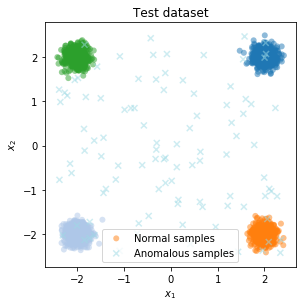

In [23]:
plt.clf()
fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/15.0),
           edgecolor='none', alpha=0.5, label="Normal samples")

ax.scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/15),
       edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')

ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Test dataset")
ax.legend()
plt.savefig(save_path_x, transparent=True, bbox_inches='tight')
plt.show()

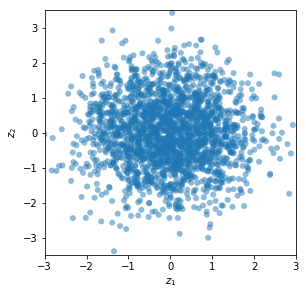

In [24]:
# create Z dataset

datasetZ_test = sample_GMM(X_np_data_test.shape[0], means_z, variances_z, priors_z, sources=('features', ))
save_path = result_dir + 'Z_gmm_data_test.png'
# plot_GMM(dataset, save_path)

Z_np_data_test = datasetZ_test.data['samples']
Z_targets_test = datasetZ_test.data['label']

fig_mx, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(Z_np_data_test[:, 0], Z_np_data_test[:, 1],
           edgecolor='none', alpha=0.5)
ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(save_path, transparent=True, bbox_inches='tight')
plt.show()

In [33]:
### Testing
gen(z).data.numpy()

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [26]:
x = torch.Tensor(X_np_data_test) 
z = torch.Tensor(Z_np_data_test)
"""imz = sess.run(q_z, feed_dict=feed_dict)
rmz = sess.run(rec_z, feed_dict=feed_dict)
imx = sess.run(p_x, feed_dict=feed_dict)
rmx = sess.run(rec_x, feed_dict=feed_dict)"""

imx = gen(z).data.cpu().numpy()
imz = inf(x).data.cpu().numpy()
rmz = inf(imx).data.cpu().numpy()
rmx = gen(imz).data.cpu().numpy()


mahalanobis_dis_z = torch.norm(inf(x), p=2, dim=1)

score_dz = mahalanobis_dis_z

score = score_dz #+ score_dxx
score = np.linalg.norm(imz, ord=2, axis=1, keepdims = False)
print(score)
def zmar(imz):
    return np.linalg.norm(imz, ord=2, axis=1, keepdims=False)



TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

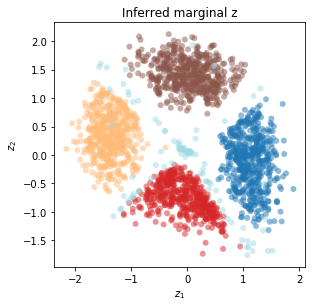

In [21]:
## inferred marginal z
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ll = X_targets_test
ax.scatter(imz[:, 0], imz[:, 1], c=cm.tab20(ll.astype(float)/input_dim/3.0),
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title("Inferred marginal z")
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



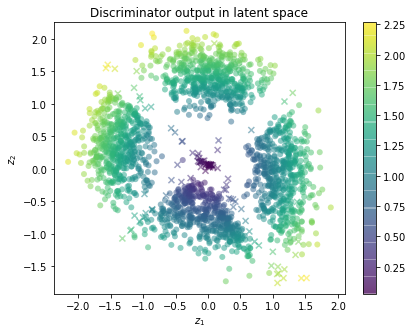

In [22]:
import matplotlib as mpl

## discriminator z choice on latent - v3
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

colors = score#zmar(score)
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))

im = ax.scatter(imz[idx_inliers, 0], imz[idx_inliers, 1], c=colors[idx_inliers],
        edgecolor='none', alpha=0.5, label="Normal samples", marker='o', norm=norm)

im = ax.scatter(imz[idx_outliers, 0], imz[idx_outliers, 1], c=colors[idx_outliers],
        edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x', norm=norm)

#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
fig_mz.colorbar(im)
ax.axis('on')
plt.axis('equal')
ax.set_title("Discriminator output in latent space")
plt.savefig(result_dir + 'inferred_{}_mz_disc.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



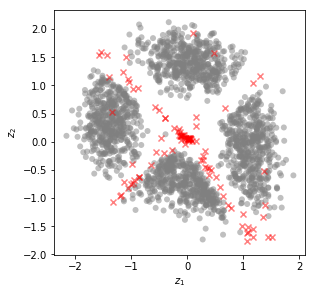

In [23]:
## discriminator z choice on latent - v2
fig_mz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(imz[idx_inliers][:, 0], imz[idx_inliers][:, 1], c='grey',
        edgecolor='none', alpha=0.5)
ax.scatter(imz[idx_outliers][:, 0], imz[idx_outliers][:, 1], c='r',
        edgecolor='none', alpha=0.5, marker='x')
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
plt.savefig(result_dir + 'inferred_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

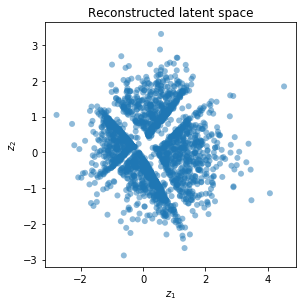

In [24]:


##  reconstructed z
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))

ax.scatter(rmz[:, 0], rmz[:, 1],
           edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$z_1$'); ax.set_ylabel('$z_2$')
ax.axis('on')
ax.set_title('Reconstructed latent space')
plt.savefig(result_dir + 'reconstruct_{}_mz.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()



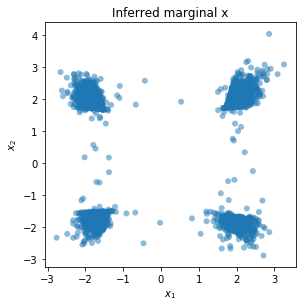

In [25]:
## inferred marginal x
fig_pz, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.scatter(imx[:, 0], imx[:, 1],
        edgecolor='none', alpha=0.5)
#ax.set_xlim(-3, 3); ax.set_ylim(-3.5, 3.5)
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
ax.axis('on')
ax.set_title("Inferred marginal x")
plt.savefig(result_dir + 'inferred_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

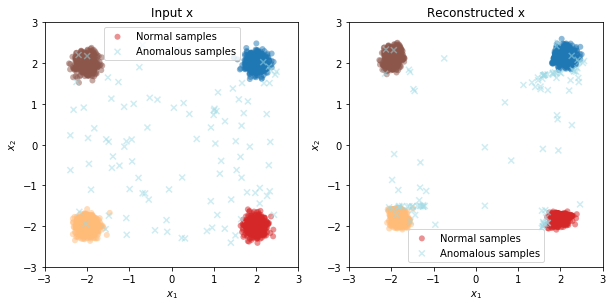

In [26]:
##  reconstructed x
fig_mx, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4.5))
ax[0].scatter(X_np_data_test[idx_inliers, 0], X_np_data_test[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[0].scatter(X_np_data_test[idx_outliers, 0], X_np_data_test[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[0].set_xlabel('$x_1$'); ax[0].set_ylabel('$x_2$')
ax[0].axis('on')
ax[0].set_xlim(-3, 3); ax[0].set_ylim(-3, 3)
ax[0].legend()
ax[0].set_title("Input x")

ax[1].scatter(rmx[idx_inliers, 0], rmx[idx_inliers, 1], c=cm.tab20(X_targets_test[idx_inliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Normal samples")
ax[1].scatter(rmx[idx_outliers, 0], rmx[idx_outliers, 1], c=cm.tab20(X_targets_test[idx_outliers].astype(float)/input_dim/3.0),
           edgecolor='none', alpha=0.5, label="Anomalous samples", marker='x')
ax[1].set_xlim(-3, 3); ax[1].set_ylim(-3, 3)
ax[1].set_xlabel('$x_1$'); ax[1].set_ylabel('$x_2$')
ax[1].axis('on')
ax[1].legend()
ax[1].set_title("Reconstructed x")
plt.savefig(result_dir + 'reconstruct_{}_mx.png'.format(DATASET), transparent=True, bbox_inches='tight')
plt.show()

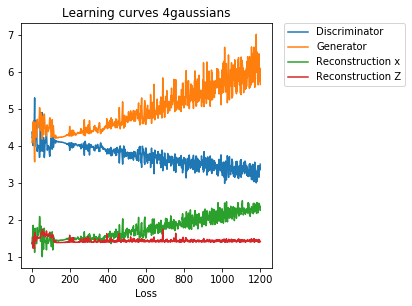

In [27]:

## learning curves
fig_curve, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4.5))
ax.plot(FD, label="Discriminator")
ax.plot(np.array(FG)[:,0], label="Generator")
ax.plot(np.array(FG)[:,1], label="Reconstruction x")
ax.plot(np.array(FG)[:,2], label="Reconstruction Z")
plt.xlabel('Iteration')
plt.xlabel('Loss')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('on')
ax.set_title("Learning curves {}".format(DATASET))
plt.savefig(result_dir + 'learning_curves_{}.png'.format(DATASET), bbox_inches='tight')
plt.show()
